# Import of packages

In [1]:
'''To install the required packages that are not included in Colaboratory.'''
#Installation of packages that are not included in Colaboratory
!pip install kneed
!pip install osmnx

'''To install a specific version of the matplotlib package.'''
!pip install matplotlib==3.1.3

'''To import the required packages.'''
import pandas as pd
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import os
import matplotlib.image as mpimg

from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import osmnx as ox

  Using cached matplotlib-3.4.1-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp38-cp38-macosx_10_9_x86_64.whl (13.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

osmnx 1.0.1 requires matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.


/Users/pol/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Settings

In [2]:
'''To display all output results of a Jupyter cell.'''
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
'''To ensure that the output results of extensive output results are not truncated.'''
#pd.options.display.max_rows = 4000

'To ensure that the output results of extensive output results are not truncated.'

# File locations


In [4]:
'''If your computer is a Windows and that you are using the file locally (repository_loc == os.getcwd()) put True, False otherwise'''
windows_locally = False 

'If your computer is a Windows and that you are using the file locally (repository_loc == os.getcwd()) put True, False otherwise'

In [5]:
'''Register the GitHub link or the file relative location (select one)'''
#the Github link
#repository_loc, windows_locally = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main", False
#the local link
repository_loc = os.getcwd()

'Register the GitHub link or the file relative location (select one)'

In [6]:
'''Get the other folder locations'''

stops_cleaned_loc = repository_loc + '/stops_cleaned/'
df_for_edges_loc = repository_loc + '/df_for_edges/'
routes_loc = repository_loc + '/routes/'
coutries_train_networks_loc = repository_loc + '/countries_train_networks'
images_loc = repository_loc + '/images/'

if windows_locally:
    stops_cleaned_loc = stops_cleaned_loc.replace('/', " \\ ").replace(' ', "")
    df_for_edges_loc = df_for_edges_loc.replace('/', " \\ ").replace(' ', "")
    routes_loc = routes_loc.replace('/', " \\ ").replace(' ', "")    
    coutries_train_networks_loc = coutries_train_networks_loc.replace('/', "\\ ").replace(' ', "") 
    images_loc = images_loc.replace('/', "\\ ").replace(' ', "") 

'Get the other folder locations'

# Import of the DataFrames

In [7]:
''' To import the df_for_edges dfs'''
df_for_edges_Belgium = pd.read_csv( df_for_edges_loc + 'df_for_edges_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
df_for_edges_Netherlands = pd.read_csv(df_for_edges_loc + 'df_for_edges_Netherlands.csv', sep=",").drop(columns = ['Unnamed: 0'])
df_for_edges_Switzerland = pd.read_csv(df_for_edges_loc + 'df_for_edges_Switzerland.csv', sep=",").drop(columns = ['Unnamed: 0'])

' To import the df_for_edges dfs'

In [8]:
''' To import the stops_cleaned df'''
stops_cleaned_Belgium = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
stops_cleaned_Netherlands = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Netherlands.csv', sep=",")
stops_cleaned_Switzerland = pd.read_csv(stops_cleaned_loc + 'stops_cleaned_Switzerland.csv', sep=",")

' To import the stops_cleaned df'

In [9]:
''' To import routes df'''
belgian_routes_Belgium = pd.read_csv(routes_loc + 'belgian_routes_Belgium.csv', sep=",").drop(columns = ['Unnamed: 0'])
dutch_routes_Netherlands = pd.read_csv(routes_loc + 'dutch_routes_Netherlands.csv', sep=",").drop(columns = ['Unnamed: 0'])
swiss_routes_Switzerland = pd.read_csv(routes_loc + 'swiss_routes_Switzerland.csv', sep=",").drop(columns = ['Unnamed: 0'])

' To import routes df'

# Research question 1: How similar are railway systems in terms of their global network metrics? Comparison of the railway systems in space-of-stops representation

## Functions

In [10]:
''' To construct the network graph for the country '''
def create_graph(df_for_edges):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df_for_edges, 'stop_name_1', 'stop_name_2')
    return G

' To construct the network graph for the country '

In [11]:
''' To assign weights to the network graph for the country'''
def assign_weights (G, df_for_edges, stops_cleaned):
    # To assign node weights to graph
    for i in range(len(stops_cleaned)):
        for n, d in G.nodes(data=True):
            if stops_cleaned.stop_name[i] == n:
                G.nodes[n]['id']=stops_cleaned.stop_id[i]
                G.nodes[n]['latitude']=stops_cleaned.stop_lat[i]
                G.nodes[n]['longitude']=stops_cleaned.stop_lon[i]
                G.nodes[n]['country']=stops_cleaned.country[i]

    # To assign edge weights to the graph: the edge weight represents a list that contains all route_ids that cover that edge
    routes_on_edge = {}
    for node1,node2, edgeData in G.edges(data = True):
        if (node1, node2) not in routes_on_edge:
                routes_on_edge[(node1, node2)] = set()
        route_id_node1_node2= df_for_edges[(df_for_edges['stop_name_1'] == node1 ) & (df_for_edges['stop_name_2'] == node2 )]['route_id']
        route_id_node2_node1= df_for_edges[(df_for_edges['stop_name_1'] == node2 ) & (df_for_edges['stop_name_2'] == node1 )]['route_id']
        for route_id in pd.concat([route_id_node1_node2, route_id_node2_node1]):
            routes_on_edge[(node1, node2)].add(route_id)
        edgeData['route_id'] = routes_on_edge[(node1, node2)] 

    return G

' To assign weights to the network graph for the country'

In [12]:
'''Calculates the average degree'''
def avg_degree(G):
    sum_degrees = 0
    for n in G.nodes():
        sum_degrees += G.degree[n]
    return (sum_degrees/len(G.nodes()))

'Calculates the average degree'

In [13]:
'''Calculates the gamma index'''
def gamma_index(G):
    return len(G.edges()) / (3*(len(G.nodes()) - 2))

'Calculates the gamma index'

In [14]:
''' The degree distribution of the country railway system'''
def degree_distribution(G):

    #Sort degree values
    degree_sequence=sorted([d for n, d in G.degree()], reverse=True)

    #Count number of frequences of degree values
    degreeCount=collections.Counter(degree_sequence)

    #Define variables deg and cnt and probability
    deg, cnt = zip(*degreeCount.items())
    probability = []
    for v in cnt:
        pv= v/len(G.nodes())
        probability.append(pv)

    #plot degree probability histogram
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, probability, width=0.95, color='lightgrey')

    #plot degree distribution
    plt.plot(deg, probability, color="b")

    #graph settings
    plt.title("Degree distribution")
    plt.ylabel("P (k)")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    #count
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, cnt, width=0.95, color='lightgrey')

    plt.plot(deg, cnt, color="b")

    #graph settings
    plt.title("Degree count")
    plt.ylabel("Count")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

' The degree distribution of the country railway system'

In [15]:
'''Creates the railway network (using the self-made Networkx graph) of the country on the country map in red. 
The white on that map is the actual railway network given by OpenStreetmaps'''

import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

def plot_given_Networkx_on_country_map(country_Networkx, country_name, country_names, dic_country_networks, dic_country_names):
    
    train_network = dic_country_networks[country_names[0]]
    country_shape = ox.geocode_to_gdf(dic_country_names[country_names[0]])
    for country in country_names[1:]:
        country_shape = pd.concat([country_shape, ox.geocode_to_gdf(dic_country_names[country])])
        train_network = nx.compose(train_network, dic_country_networks[country])

    #create an empty list of edges
    list_edges = []
    
    #add each edge to the list, by finding both of its nodes in the given OpenStreetMaps network and highlighting them
    #and finding the shortest routes between each pair of edges to highlight that route as well
    for node1,node2 in country_Networkx.edges():
        orig = ox.get_nearest_node(train_network, (country_Networkx.nodes[node1]['latitude'], country_Networkx.nodes[node1]['longitude']))
        dest = ox.get_nearest_node(train_network, (country_Networkx.nodes[node2]['latitude'], country_Networkx.nodes[node2]['longitude']))
        try:
            list_edges.append(nx.shortest_path(train_network, orig, dest))
        except nx.NetworkXNoPath:
            print(f'No path between {node1} and {node2}')
            continue

    #put the self-made railway network as a graph in red
    fig, ax = ox.plot_graph_routes(train_network, list_edges, route_color = 'r', route_linewidth = 1, show=False, close=False, edge_color='#111111', node_color='#111111', node_size=0.2, bgcolor='w')

    #plot the country on the top of the self-made railway network
    country_shape.plot(ax=ax, color='#111111', alpha=0.4)

    plt.savefig(f'{images_loc}{country_name}_Network.png') 
    plt.show()

'Creates the railway network (using the self-made Networkx graph) of the country on the country map in red. \nThe white on that map is the actual railway network given by OpenStreetmaps'

## Download the train networks of all the counties of interest

### Functions

In [16]:
'''Download all the countries train networks and store it as .gpickles files'''

def download_countries_train_Networks(dic_country_names, coutries_train_networks_loc):
    for country, osm_request in dic_country_names.items():
        train_country = ox.graph_from_place(osm_request,
                                            retain_all=False, truncate_by_edge=True, simplify=True,
                                            custom_filter='["railway"~"rail"]')
        nx.write_gpickle(train_country, f'{coutries_train_networks_loc}/train_{country}.gpickle')
    

'Download all the countries train networks and store it as .gpickles files'

In [17]:
'''Retrieve all the countries train networks and put it in the dic_country_networks dictionnary'''

def retrieve_countries_train_Networks(dic_country_names, coutries_train_networks_loc):
    dic_country_networks = {}
    for country in dic_country_names:
        train_country = nx.read_gpickle(f'{coutries_train_networks_loc}/train_{country}.gpickle')
        dic_country_networks[country] = train_country
    return dic_country_networks
    

'Retrieve all the countries train networks and put it in the dic_country_networks dictionnary'

### Acutal download

In [18]:
'''Create a dictionary with all the countries of interest'''
dic_country_names = {'Netherlands' : ['South Holland, Netherlands',{'state':'Utrecht', 'country':'Netherlands'},'North Brabant, Netherlands', 'Limburg, Netherlands','Gelderland, Netherlands', 'Overijssel, Netherlands','Drenthe, Netherlands', 'Groningen, Netherlands', 'Friesland, Netherlands', 'Flevoland, Netherlands', 'North Holland, Netherlands'],
                    'Belgium': ['Belgium'], 'Switzerland': ['Switzerland'], 'France': ['Metropolitan France'],
                    'Luxembourg': ['Luxembourg'], 'Germany': ['Germany'], 'Austria': ['Austria'], 'Italy': ['Italy'],
                    'Liechtenstein': ['Liechtenstein'], 'United_Kingdom': ['United Kingdom']}

'Create a dictionary with all the countries of interest'

In [19]:
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO DOWNLOAD THE COUNTRIES TRAIN NETWORKS FROM OSM, BUT IT TAKES A LONG TIME
#download_countries_train_Networks(dic_country_names, coutries_train_networks_loc)

In [20]:
dic_country_networks = retrieve_countries_train_Networks(dic_country_names, coutries_train_networks_loc)

## Acutal calculation of the global characteristics of the railway systems in the space-of-stops representation

### Belgium

In [21]:
B = create_graph(df_for_edges_Belgium)
B = assign_weights (B, df_for_edges_Belgium, stops_cleaned_Belgium)

In [22]:
'''Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'''
belgian_stops = [n for n,v in B.nodes(data=True) if v['country'] == 'Belgium']
B_belgian_stops = B.subgraph(belgian_stops)

'Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

No path between ROTTERDAM CS (NL) and DEN HAAG HS (NL)
No path between SCHIPHOL (NL) and DEN HAAG HS (NL)


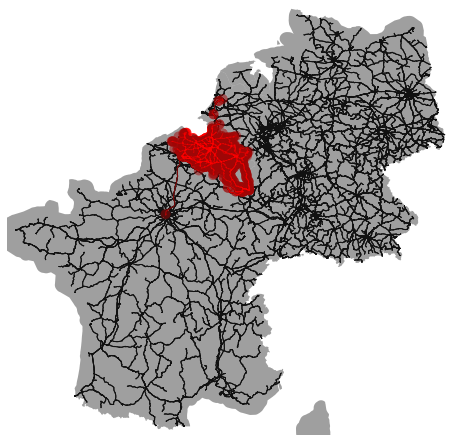

In [23]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Belgium'
country_names = ['France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(B, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

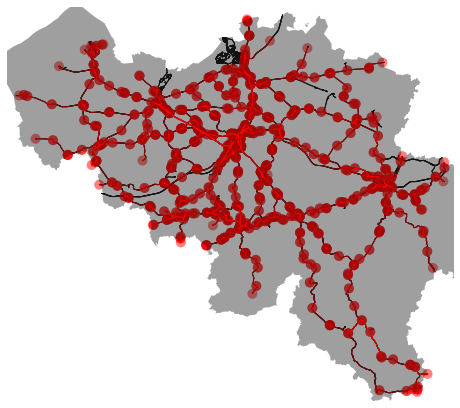

In [24]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Belgium_only'
country_names = ['Belgium']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(B_belgian_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [25]:
B.edges(data=True)

EdgeDataView([('TOURNAI', 'FROYENNES', {'route_id': {257.0, 258.0, 387.0, 385.0, 389.0, 393.0, 779.0, 780.0, 781.0, 767.0, 151.0, 536.0, 159.0, 160.0, 161.0, 825.0, 826.0, 700.0, 453.0, 724.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 115.0, 764.0, 253.0, 766.0, 383.0}}), ('TOURNAI', 'LEUZE', {'route_id': {779.0, 780.0, 781.0, 298.0, 299.0, 825.0, 826.0, 700.0, 701.0, 341.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 760.0, 243.0, 246.0, 120.0}}), ('TOURNAI', 'ANTOING', {'route_id': {384.0, 385.0, 258.0, 387.0, 389.0, 390.0, 383.0, 393.0, 395.0, 151.0, 536.0, 159.0, 160.0, 161.0, 162.0, 170.0, 705.0, 452.0, 453.0, 724.0, 767.0}}), ('FROYENNES', 'HERSEAUX', {'route_id': {385.0, 387.0, 389.0, 393.0, 779.0, 780.0, 781.0, 151.0, 536.0, 159.0, 160.0, 161.0, 825.0, 826.0, 700.0, 453.0, 724.0, 342.0, 343.0, 344.0, 345.0, 346.0, 608.0, 115.0, 253.0, 383.0}}), ('FROYENNES', 'BLANDAIN-FRONTIERE', {'route_id': {257.0, 258.0, 764.0, 766.0, 767.0}}), ('HERSEAUX', 'MOUSCRON', {'route_id': {385.0, 387

In [26]:
''' The number of nodes in the Belgian railway system '''
# The number of total nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
len(B.nodes())

# The number of belgian nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
len(B_belgian_stops.nodes())

' The number of nodes in the Belgian railway system '

608

564

In [27]:
''' The degrees of the nodes in the Belgian railway system considering only stops in Belgium'''
B_belgian_stops.degree()

' The degrees of the nodes in the Belgian railway system considering only stops in Belgium'

DegreeView({'TOURNAI': 3, 'FROYENNES': 3, 'HERSEAUX': 2, 'MOUSCRON': 4, 'BRUGES': 4, 'BRUGES-SAINT-PIERRE': 4, 'HEIST': 2, 'DUINBERGEN': 2, 'KNOKKE': 1, 'SPA-GERONSTERE': 1, 'SPA': 2, 'FRANCHIMONT': 2, 'THEUX': 2, 'JUSLENVILLE': 2, 'PEPINSTER-CITE': 2, 'PEPINSTER': 3, 'VERVIERS-CENTRAL': 2, 'GAND-SAINT-PIERRE': 7, 'DE PINTE': 3, 'DEINZE': 3, 'AARSELE': 2, 'TIELT': 2, 'LICHTERVELDE': 4, 'TORHOUT': 2, 'ZEDELGEM': 2, 'DENDERLEEUW': 5, 'IDDERGEM': 2, 'OKEGEM': 2, 'NINOVE': 2, 'EICHEM': 2, 'APPELTERRE': 2, 'ZANDBERGEN': 2, 'IDEGEM': 2, 'SCHENDELBEKE': 2, 'GRAMMONT': 4, 'ATH': 4, 'LEUZE': 2, 'CHARLEROI-SUD': 5, 'MARCHIENNE-AU-PONT': 3, 'ROUX': 2, 'COURCELLES-MOTTE': 2, 'LUTTRE': 3, 'BRUXELLES-MIDI': 9, 'BRUXELLES-CHAPELLE': 2, 'BRUXELLES-CENTRAL': 2, 'BRUXELLES-CONGRES': 2, 'BRUXELLES-NORD': 4, 'BRUXELLES-SCHUMAN': 5, 'BRUXELLES-LUXEMBOURG': 3, 'ETTERBEEK': 5, 'WATERMAEL': 2, 'BOITSFORT': 2, 'GROENENDAAL': 2, 'HOEILAART': 2, 'LA HULPE': 2, 'GENVAL': 2, 'RIXENSART': 2, 'PROFONDSART': 2, 'OTTI

In [28]:
''' The average degree of the nodes in the Belgian railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Belgian railway system that consists of all routes that cover at least one belgian station
print(avg_degree(B))

# The average degree of all the nodes in the Belgian railway system if only the belgian stations are considered
print(avg_degree(B_belgian_stops))

' The average degree of the nodes in the Belgian railway system indicating the number of directions \na commuter can take from that given station.'

2.2927631578947367
2.269503546099291


In [29]:
''' The number of edges in the Belgian railway system considering only stops in Belgium '''
len(B.edges())

' The number of edges in the Belgian railway system considering only stops in Belgium '

697

In [30]:
''' The gamma index of the Belgian railway system considering only stops in Belgium'''
print(gamma_index(B))

' The gamma index of the Belgian railway system considering only stops in Belgium'

0.3833883388338834


In [31]:
''' The mean clustering coefficient of the Belgian railway system considering only stops in Belgium'''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(B))

' The mean clustering coefficient of the Belgian railway system considering only stops in Belgium'

mean clustering coefficient: 0.04204521720969088


' The degree distribution of the Belgian railway system considering only stops in Belgian'

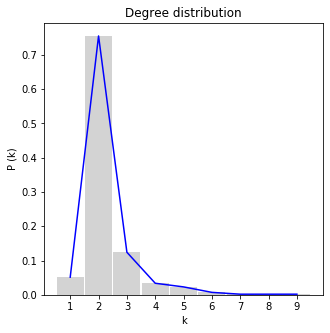

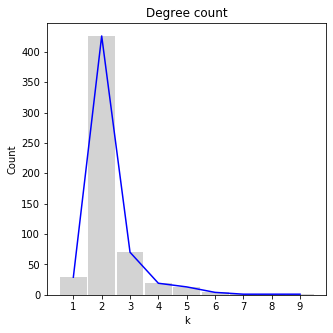

In [32]:
''' The degree distribution of the Belgian railway system considering only stops in Belgian'''
degree_distribution(B_belgian_stops)

In [33]:
''' Detection of the scale-free property in the Belgian railway system:
A PTN with the scale-free property consists of a large number of vertices 
that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Belgian railway system:\nA PTN with the scale-free property consists of a large number of vertices \nthat exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [34]:
''' The average path length of the Belgian railway system considering only stops in Belgium:
The average path length represents in the space_of_stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(B))

' The average path length of the Belgian railway system considering only stops in Belgium:\nThe average path length represents in the space_of_stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

21.69866361744559


In [35]:
''' The assortativity of the Belgian railway system considering only stops in Belgium:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected 
to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(B_belgian_stops))

' The assortativity of the Belgian railway system considering only stops in Belgium:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected \nto each other instead of being connected to vertices of the same kind.'

0.20729082485857464


### Netherlands

In [36]:
N = create_graph(df_for_edges_Netherlands)
N = assign_weights(N, df_for_edges_Netherlands, stops_cleaned_Netherlands)

In [37]:
'''Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'''
dutch_stops = [n for n,v in N.nodes(data=True) if v['country'] == 'Netherlands']
N_dutch_stops = N.subgraph(dutch_stops)

'Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

No path between GOUDA and LANSINGERLAND-ZOETERMEER
No path between LEIDEN CENTRAAL and DEN HAAG LAAN V NOI
No path between DEN HAAG CENTRAAL and DEN HAAG LAAN V NOI
No path between DEN HAAG MARIAHOEVE and DEN HAAG LAAN V NOI
No path between ZOETERMEER OOST and ZOETERMEER
No path between LONDON ST. PANCRAS INT. and LILLE EUROPE
No path between AVIGNON TGV and VALENCE TGV


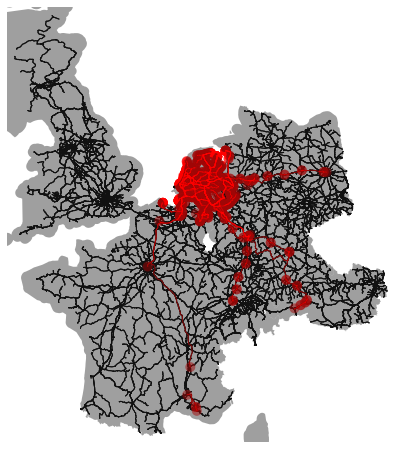

In [38]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Netherlands'
country_names = ['France', 'Belgium', 'Netherlands', 'United_Kingdom', 'Germany', 'Austria', 'Switzerland']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(N, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

No path between GOUDA and LANSINGERLAND-ZOETERMEER
No path between LEIDEN CENTRAAL and DEN HAAG LAAN V NOI
No path between DEN HAAG CENTRAAL and DEN HAAG LAAN V NOI
No path between DEN HAAG MARIAHOEVE and DEN HAAG LAAN V NOI
No path between ZOETERMEER OOST and ZOETERMEER


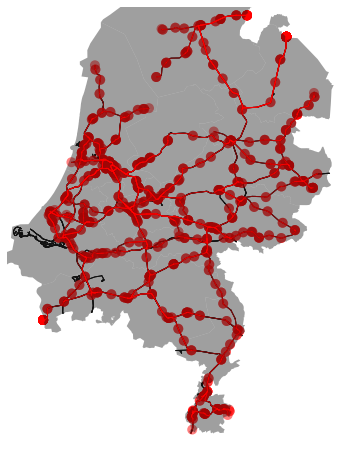

In [39]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Netherlands_only'
country_names = ['Netherlands']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(N_dutch_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [40]:
N.edges(data=True)

EdgeDataView([('ROTTERDAM CENTRAAL', 'SCHIPHOL AIRPORT', {'route_id': {59426.0, 17795.0, 17615.0, 17522.0, 75065.0, 77595.0}}), ('ROTTERDAM CENTRAAL', 'ROTTERDAM ALEXANDER', {'route_id': {17562.0, 41210.0, 17614.0}}), ('ROTTERDAM CENTRAAL', 'BREDA', {'route_id': {67394.0, 59426.0, 77636.0, 17615.0, 75062.0, 76990.0}}), ('ROTTERDAM CENTRAAL', 'ROTTERDAM NOORD', {'route_id': {41200.0, 17651.0, 17748.0}}), ('ROTTERDAM CENTRAAL', 'ANTWERPEN-CENTRAAL', {'route_id': {75065.0, 77595.0, 17795.0}}), ('ROTTERDAM CENTRAAL', 'ROTTERDAM BLAAK', {'route_id': {41202.0, 66117.0, 41238.0, 41239.0}}), ('ROTTERDAM CENTRAAL', 'SCHIEDAM CENTRUM', {'route_id': {41202.0, 66117.0, 41238.0, 41239.0}}), ('ROTTERDAM CENTRAAL', 'GOUDA', {'route_id': {66765.0, 77622.0, 77623.0}}), ('ROTTERDAM CENTRAAL', 'DELFT', {'route_id': {67394.0, 67402.0, 77630.0, 77631.0}}), ('ROTTERDAM CENTRAAL', 'DORDRECHT', {'route_id': {67395.0}}), ('ROTTERDAM CENTRAAL', 'BRUSSEL-ZUID/MIDI', {'route_id': {75060.0}}), ('ROTTERDAM CENTRAAL

In [41]:
''' The number of nodes in the Dutch railway system '''
# The number of total nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
len(N.nodes())

# The number of dutch nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
print(len(N_dutch_stops.nodes()))

' The number of nodes in the Dutch railway system '

519

394


In [42]:
''' The degrees of the nodes in the Dutch railway system considering only stops in Netherlands'''
N_dutch_stops.degree()

' The degrees of the nodes in the Dutch railway system considering only stops in Netherlands'

DegreeView({'ROTTERDAM CENTRAAL': 11, 'SCHIPHOL AIRPORT': 9, 'AMSTERDAM CENTRAAL': 12, 'ROTTERDAM ALEXANDER': 4, 'GOUDA': 11, 'UTRECHT CENTRAAL': 18, 'LEIDEN CENTRAAL': 11, 'LEIDEN LAMMENSCHANS': 2, 'ALPHEN A/D RIJN': 3, 'BODEGRAVEN': 2, 'WOERDEN': 5, 'HOOFDDORP': 3, 'AMSTERDAM ZUID': 5, 'AMSTERDAM RAI': 2, 'DUIVENDRECHT': 7, 'DIEMEN ZUID': 2, 'WEESP': 4, 'ALMERE POORT': 3, 'ALMERE MUZIEKWIJK': 2, 'ALMERE CENTRUM': 7, 'ALMERE PARKWIJK': 2, 'ALMERE BUITEN': 4, 'ALMERE OOSTVAARDERS': 2, 'AMERSFOORT SCHOTHORST': 2, 'AMERSFOORT CENTRAAL': 10, 'DEN HAAG CENTRAAL': 5, 'GRONINGEN': 5, 'ASSEN': 4, 'ZWOLLE': 11, 'BREDA': 6, 'LEEUWARDEN': 7, 'GROU-JIRNSUM': 2, 'AKKRUM': 2, 'HEERENVEEN': 4, 'WOLVEGA': 2, 'STEENWIJK': 3, 'MEPPEL': 3, 'BAARN': 3, 'SOESTDIJK': 2, 'SOEST': 2, 'SOEST ZUID': 2, 'DEN DOLDER': 3, 'BILTHOVEN': 2, 'UTRECHT OVERVECHT': 4, 'AMERSFOORT VATHORST': 2, 'NIJKERK': 4, 'PUTTEN': 2, 'ERMELO': 2, 'HARDERWIJK': 3, 'NUNSPEET': 2, "HARDE ('T)": 2, 'WEZEP': 2, 'UTRECHT LEIDSCHE RIJN': 2,

In [43]:
''' The average degree of the nodes in the Dutch railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Dutch railway system that consists of all routes that cover at least one dutch station
print(avg_degree(N))

# The average degree of all the nodes in the Dutch railway system if only the dutch stations are considered
print(avg_degree(N_dutch_stops))

' The average degree of the nodes in the Dutch railway system indicating the number of directions \na commuter can take from that given station.'

2.6666666666666665
2.771573604060914


In [44]:
''' The number of edges in the Dutch railway system considering only the stops in Netherlands'''
len(N.edges())

' The number of edges in the Dutch railway system considering only the stops in Netherlands'

692

In [45]:
''' The gamma index of the Dutch railway system considering only the stops in Netherlands'''
print(gamma_index(N))

' The gamma index of the Dutch railway system considering only the stops in Netherlands'

0.44616376531270147


In [46]:
''' The mean clustering coefficient of the Dutch railway system considering only the stops in Netherlands'''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(N))

' The mean clustering coefficient of the Dutch railway system considering only the stops in Netherlands'

mean clustering coefficient: 0.10406279151603876


' The degree distribution of the Dutch railway system considering only stops in Netherlands'

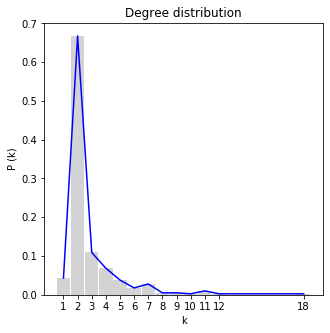

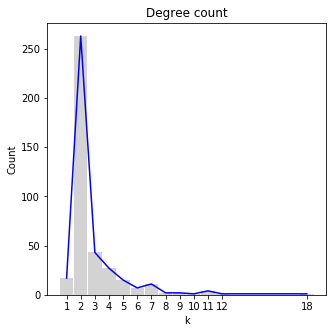

In [47]:
''' The degree distribution of the Dutch railway system considering only stops in Netherlands'''
degree_distribution(N_dutch_stops)

In [48]:
''' Detection of the scale-free property in the Dutch railway system:
A PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher")

' Detection of the scale-free property in the Dutch railway system:\nA PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher


In [49]:
''' The average path length of the Dutch railway system considering only the stops in Netherlands:
The average path length represents in the space-of-stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(N))

' The average path length of the Dutch railway system considering only the stops in Netherlands:\nThe average path length represents in the space-of-stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

9.916746639289991


In [50]:
''' The assortativity of the Dutch railway system considering only the stops in Netherlands:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected 
to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(N_dutch_stops))

' The assortativity of the Dutch railway system considering only the stops in Netherlands:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected \nto each other instead of being connected to vertices of the same kind.'

0.2365574463964469


### Switzerland

In [51]:
S = create_graph(df_for_edges_Switzerland)
S = assign_weights(S, df_for_edges_Switzerland, stops_cleaned_Switzerland)

In [52]:
'''Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'''
swiss_stops = [n for n,v in S.nodes(data=True) if v['country'] == 'Switzerland']
S_swiss_stops = S.subgraph(swiss_stops)

'Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'

'Show the country train network that was created by create_graph() on the map'

No path between AVIGNON TGV and LYON PART DIEU
No path between BELLEGARDE (AIN) and POUGNY-CHANCY
No path between RUSSIN and POUGNY-CHANCY
No path between LA PLAINE and POUGNY-CHANCY


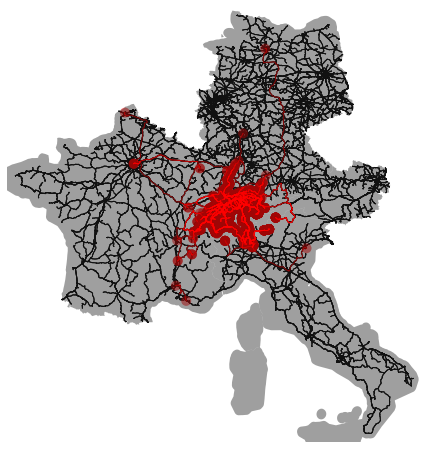

In [53]:
'''Show the country train network that was created by create_graph() on the map'''
country_name = 'Switzerland'
country_names = ['France', 'Germany', 'Austria', 'Switzerland', 'Italy', 'Liechtenstein']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(S, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

'Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'

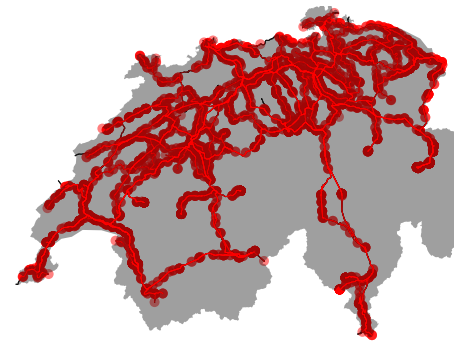

In [54]:
'''Show the country train network subgraph that was created by create_graph() and then filtered on the country stops on the map'''
country_name = 'Switzerland_only'
country_names = ['Switzerland']
#THE FOLLOWING LINE MIGHT BE RUNNED IF WANTED TO RECALCULATE AND SHOW THE ROUTE CREATED ON THE MAP, BUT IT TAKES A LONG TIME
#plot_given_Networkx_on_country_map(S_swiss_stops, country_name, country_names, dic_country_networks, dic_country_names)
img = mpimg.imread(f'{images_loc}{country_name}_Network.png')
imgplot = plt.imshow(img)
plt.show()

In [55]:
S.edges(data=True)

EdgeDataView([('LES BRENETS', 'LES FRETES', {'route_id': {'00001.000044.018:1'}}), ('LES FRETES', 'LE LOCLE LE CHALET', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE LE CHALET', 'LE LOCLE', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE', 'LE CRET-DU-LOCLE', {'route_id': {'06350.000011.101:6350', '07205.000011.101:7205', '07237.000011.101:7237'}}), ('BRIENZ BRB', 'PLANALP', {'route_id': {'00001.000104.001:1', '00071.000104.001:71'}}), ('PLANALP', 'BRIENZER ROTHORN', {'route_id': {'00001.000104.001:1'}}), ('BASEL BAD BF', 'BASEL SBB', {'route_id': {'00373.000011.102:373', '00471.000011.101:471', '00151.000011.101:151', '00273.000011.104:273', '00003.000011.101:3', '00003.000011.107:3', '00004.000011.102:4', '00006.000011.102:6', '00006.000011.101:6', '05320.000011.105:5320', '00052.000011.101:52'}}), ('BASEL BAD BF', 'HAMBURG-ALTONA', {'route_id': {'00273.000011.104:273'}}), ('BASEL BAD BF', 'RHEINFELDEN (BADEN)', {'route_id': {'03065.800693.001:3065', '03053.800693.002:3053', '0

In [56]:
''' The number of nodes in the Swiss railway system '''
# The number of total nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
len(S.nodes())

# The number of swiss nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
print(len(S_swiss_stops.nodes()))

' The number of nodes in the Swiss railway system '

1901

1704


In [57]:
''' The degrees of the nodes in the Swiss railway system considering only stops in Switzerland'''
S_swiss_stops.degree()

' The degrees of the nodes in the Swiss railway system considering only stops in Switzerland'

DegreeView({'LES BRENETS': 1, 'LES FRETES': 2, 'LE LOCLE LE CHALET': 2, 'LE LOCLE': 2, 'BRIENZ BRB': 1, 'PLANALP': 2, 'BRIENZER ROTHORN': 1, 'BASEL BAD BF': 3, 'BASEL SBB': 12, 'HAUENSTEIN-BASISTUNNEL': 2, 'ZURICH HB': 23, 'ZIMMERBERG-BASISTUNNEL': 3, 'SARGANS': 9, 'LANDQUART': 11, 'CHUR': 14, 'TASCH': 2, 'ZERMATT': 2, 'STE-CROIX': 1, 'SIX-FONTAINES': 2, 'BAULMES': 2, 'VUITEBOEUF': 2, 'ESSERT-SOUS-CHAMPVENT': 2, 'VALEYRES-SOUS-MONTAGNY': 2, 'LA BRINAZ': 3, 'YVERDON-LES-BAINS': 10, 'YVERDON WILLIAM BARBEY': 2, 'ALPNACHSTAD PB': 1, 'AEMSIGEN': 2, 'PILATUS KULM': 1, 'BLONAY': 5, 'CHAMBY': 5, 'CHAMBY-MUSEE': 2, 'INTERLAKEN OST': 5, 'INTERLAKEN WEST': 2, 'SPIEZ': 8, 'THUN': 8, 'BERN': 25, 'BAHN-2000-STRECKE': 5, 'OLTEN': 25, 'LIESTAL': 7, 'AIGLE': 8, 'AIGLE-HOPITAL': 2, 'ST-TRIPHON-VILLAGE': 2, 'OLLON VD': 2, 'LES ARNOUX': 2, 'VILLY': 2, 'ST-TRIPHON-GARE': 2, 'PONT DU RHONE': 2, 'CORBIER': 2, 'COLLOMBEY-MURAZ': 2, 'MONTHEY-EN PLACE': 3, 'MONTHEY-VILLE': 1, 'MONTHEY-HOPITAL': 2, 'CHEMEX': 2,

In [58]:
''' The average degree of the nodes in the Swiss railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Swiss railway system that consists of all routes that cover at least one Swiss station
print(avg_degree(S))

# The average degree of all the nodes in the Swiss railway system if only the Swiss stations are considered
print(avg_degree(S_swiss_stops))

' The average degree of the nodes in the Swiss railway system indicating the number of directions \na commuter can take from that given station.'

2.689110994213572
2.6737089201877935


In [59]:
''' The number of edges in the Swiss railway system considering only stops in Switzerland'''
len(S.edges())

' The number of edges in the Swiss railway system considering only stops in Switzerland'

2556

In [60]:
''' The gamma index of the Swiss railway system considering only stops in Switzerland'''
print(gamma_index(S))

' The gamma index of the Swiss railway system considering only stops in Switzerland'

0.4486571879936809


In [61]:
''' The mean clustering coefficient of the Swiss railway system considering only stops in Switzerland'''
#The mean clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean clustering coefficient:", nx.average_clustering(S))

' The mean clustering coefficient of the Swiss railway system considering only stops in Switzerland'

mean clustering coefficient: 0.1584090006903548


' The degree distribution of the Swiss railway system considering only stops in Switzerland'

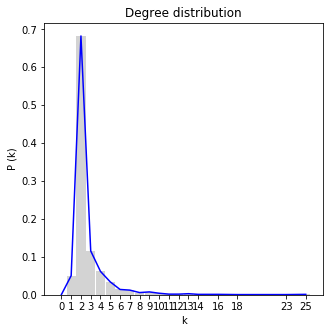

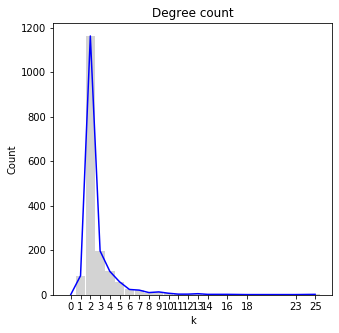

In [62]:
''' The degree distribution of the Swiss railway system considering only stops in Switzerland'''
degree_distribution(S_swiss_stops)

In [63]:
''' Detection of the scale-free property in the Swiss railway system:
A PTN with the scale-free property consists of a large number of vertices 
that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Swiss railway system:\nA PTN with the scale-free property consists of a large number of vertices \nthat exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [64]:
'''Separate all the connected subgraphs of Switzerland. And see what we lose by only taking the largest one.'''
all_connected_graphs = nx.connected_components(S)
largest_component = max(nx.connected_components(S), key=len)
largest_connected_subgraph = S.subgraph(largest_component)
lost_number_nodes = len(S.nodes()) - len(largest_connected_subgraph)
print(f'lost number of nodes: {lost_number_nodes}')
list_subgraphs_except_max = []
for sg in all_connected_graphs:
    if sg != largest_component:
        list_subgraphs_except_max.append(sg)

set_deleted_routes = set()
for sg in list_subgraphs_except_max:
    for n1, n2, edge_data in S.subgraph(sg).edges(data=True):
        set_deleted_routes.update(edge_data['route_id'])
        
print(f'lost number of routes: {len(set_deleted_routes)}')

'Separate all the connected subgraphs of Switzerland. And see what we lose by only taking the largest one.'

lost number of nodes: 163
lost number of routes: 56


In [65]:
''' The average path length of the Swiss railway system considering only stops in Switzerland:
The average path length represents in the space-of-stops the average of all the shortest paths 
to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(largest_connected_subgraph))

' The average path length of the Swiss railway system considering only stops in Switzerland:\nThe average path length represents in the space-of-stops the average of all the shortest paths \nto be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

11.943739884580706


In [66]:
''' The assortativity of the Swiss railway system considering only stops in Switzerland:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(S_swiss_stops))

' The assortativity of the Swiss railway system considering only stops in Switzerland:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'

0.2335121037448794


# RQ2: comparison of the Belgian NMBS/SNCB, the Dutch NS and the Swiss SBB railway systems in terms of the average planned travel time of similar routes

## Clustering preparation

### Functions

In [67]:
''' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'''
def create_route_characteristics(df_for_edges):
    # To create a list of all unique route_ids in the df_for_edges dataset
    routes_list = list(df_for_edges['route_id'].unique())
    routes_list.sort()

    # To create a dataframe that contains the values in the route_characteristics_Belgium_dic as the values in the first column'''
    route_characteristics = pd.DataFrame(routes_list, columns=['route_id'])
    return route_characteristics

' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'

In [68]:
''' To put the stations per route_id in df route_characteristics_Belgium'''
def put_stations_route_characteristics(G, route_characteristics):
    # To construct a new column of the route_characteristics_Belgium dataset that has for every column value an empty set
    route_characteristics['nodes'] = [set() for _ in range(len(route_characteristics))]

    # To put the two nodes of an edge in the nodes column of the route_characteristics_Belgium dataset if the route_id of the corresponding row 
    # is present in the set of the list values of the corresponding edge that contains all route_ids that contain the edge
    for node1, node2 in G.edges():
        route_characteristics[['route_id','nodes']].apply(lambda x: x['nodes'].update((node1, node2)) if x['route_id'] in set(G.get_edge_data(node1, node2)['route_id']) else x, axis = 1)
    return route_characteristics

' To put the stations per route_id in df route_characteristics_Belgium'

In [69]:
'''Deletes every empty route (useful after a inside contry filter)'''
def deletes_empty_routes(route_characteristics):
    index_empty_routes = route_characteristics_Belgium_belgian_nodes[route_characteristics_Belgium_belgian_nodes['nodes'].map(lambda d: len(d)) == 0].index
    return route_characteristics.drop(index_empty_routes)

'Deletes every empty route (useful after a inside contry filter)'

In [70]:
''' Definitions to calculate route topological metrics'''

# The inputs of the get_metric_list function are a dictionary that contains for all node keys the corresponding metric values and a specific route_id of a column of 
# the route_characteristics dataset
# A new empty list metric_list is created for these inputs
# For the nodes that are in the route_characteristics dataset corresponding to this route_id, the corresponding metric values from the dictionary get appended to metric_list

from statistics import mean
def get_metric_list(route_characteristics, metric_dic, route_id):
    """this is a sub function that is used in calculate_metric_route_per_node"""
    metric_list = []
    for nodes in route_characteristics[route_characteristics['route_id'] == route_id]['nodes']:
        for node in nodes:
            metric_list.append(metric_dic[node])
    return metric_list

# For the metric, a new column is created in route_characteristics, where every column value consists of an empty list
# The values in the column of the df are determined by giving the metric_dic and the route_id of the row where that value is placed to the get_metric_list function
# The metric_list ultimately contains the metric values for a specific metric for all the stations corresponding to that route

def calculate_metric_route_per_node(route_characteristics, metric_dic, metric_name):
    """puts the metrics of each node of a route in a list in the route_characteristics df"""
    route_characteristics[metric_name] = [list for _ in range(len(route_characteristics))]
    route_characteristics[metric_name] = route_characteristics.apply(lambda x: get_metric_list(route_characteristics, metric_dic, x['route_id']) , axis = 1)
    
# The function starts from the metric_name, the original_metric_name and the aggregation_method inputs
# A new column named with the metric_name is created: initially it contains all NaN values
# Thereafter the aggregation_method is taken into account. The avg aggregation method returns for all column values the mean of the values in the corresponding row
# of the original_metric_name list. The max aggregation method returns for all column values the max of the values in the corresponding row of the original_metric_name list.

def calculate_metric_aggregation_route(route_characteristics, metric_name, original_metric_name, aggregation_method):
    '''calculate the metric aggregation of the routes, only avg and max are supported as string values for aggregation method
    metric_name is the aggregation column name and original_metric_name is the node metric column name'''
    route_characteristics[metric_name] = np.nan
    if aggregation_method == 'avg':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: mean(x[original_metric_name]) , axis = 1)
    elif aggregation_method == 'max':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: max(x[original_metric_name]) , axis = 1)

' Definitions to calculate route topological metrics'

In [71]:
'''Calculate the metrics of the route_characteristics df'''
def calculate_characteristics (G, route_characteristics):
    calculate_metric_route_per_node(route_characteristics, dict(G.degree()), 'node_degree')
    calculate_metric_aggregation_route(route_characteristics, 'avg_degree', 'node_degree', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_degree', 'node_degree', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.clustering(G)), 'node_clustering')
    calculate_metric_aggregation_route(route_characteristics, 'avg_clustering', 'node_clustering', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_clustering', 'node_clustering', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.closeness_centrality(G)), 'node_closeness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_closeness_centrality', 'node_closeness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_closeness_centrality', 'node_closeness_centrality', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.betweenness_centrality(G)), 'node_betweenness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_betweenness_centrality', 'node_betweenness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_betweenness_centrality', 'node_betweenness_centrality', 'max')
    return route_characteristics

'Calculate the metrics of the route_characteristics df'

In [72]:
''' To add the number of stations present in the stop sequence of a route_id'''
def add_number_stations(route_characteristics):
    number_stations = []
    for number_stops in route_characteristics['nodes']:
        number_stations.append(len(number_stops))

    route_characteristics['len_stop_sequence'] = number_stations
    return route_characteristics

' To add the number of stations present in the stop sequence of a route_id'

In [73]:
''' To add the absolute distances between the starting and the ending station of all routes, and waiting and travel time'''

def add_absolute_distance_tt_wt(route_characteristics, routes_country):

    route_characteristics = route_characteristics.merge(routes_country[['route_id', 'distance','travel_time', 'waiting_time']], on='route_id')
    route_characteristics = route_characteristics.rename(columns = {'distance': 'absolute_distance'})
    return route_characteristics

' To add the absolute distances between the starting and the ending station of all routes, and waiting and travel time'

In [74]:
''' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'''

def add_relative_distance (route_characteristics):
    # The relative distance of a route is the distance of the route divided by the distance of the route with the longest distance
    relative_distance = []

    # To calculate the route which stop sequence has the greatest absolute distance
    max_distance = route_characteristics['absolute_distance'].max()

    # To calculate the relative distance of each route
    for abs_distance in route_characteristics['absolute_distance']:
        rel_distance = abs_distance / max_distance
        relative_distance.append(rel_distance)

    # To add the relative_distance list as a column to the route_characteristics dataset
    route_characteristics['relative_distance'] = relative_distance
    return route_characteristics

' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'

In [75]:
''' To add the absolute distances between the starting and the ending station of all routes'''

# Remember that geographical locations that are located further away to the right of the Prime Meridian Greenwich instead of another location that is closer
# (but still to the right) of this Meridian Greenwich, have a greater longitute value.
# Remember that geographical locations that are higher above the Equator than other geographical locations (that are also above the Equator), have a 
# higher latitude value

def add_absolute_distance_begin_end(route_characteristics, df_for_edges, stops_cleaned):

    absolute_distance = []
    for route in route_characteristics['route_id']:
        subdf_stop_sequence = df_for_edges[df_for_edges['route_id'] == route]
        number_of_rows = len(subdf_stop_sequence.index)

        # To get the starting station and the ending_station of the stop sequence of a route
        starting_station = subdf_stop_sequence['stop_name_1'].iloc[0]
        ending_station = subdf_stop_sequence['stop_name_2'].iloc[number_of_rows - 1]

        # The radius of the earth
        R = 6373.0

        # To convert the coordinates in radians 
        lat_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lat'].iloc[0])
        lon_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lon'].iloc[0])
        lat_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lat'].iloc[0])
        lon_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lon'].iloc[0])

        # To calculate the change in coordinates
        dlon = lon_ending_station - lon_starting_station
        dlat = lat_ending_station - lat_starting_station

        # To use the Haversine formula to get the distance in kilometers between the starting_station and the ending_station
        a = math.sin(dlat / 2)**2 + math.cos(lat_starting_station) * math.cos(lat_ending_station) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        # To calculate the distance
        distance = R * c

        # To add the distance in the absolute_distance list
        absolute_distance.append(distance)

    # To add the absolute_distance list as a column to the route_characteristics dataset
    route_characteristics['absolute_distance_begin_end'] = absolute_distance
    return route_characteristics

' To add the absolute distances between the starting and the ending station of all routes'

### Actual clustering preparation

#### Belgium

In [76]:
'''Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'''
belgian_stops = [n for n,v in B.nodes(data=True) if v['country'] == 'Belgium']
B_belgian_stops = B.subgraph(belgian_stops)

'Calculates the subgraph that contains only stops into Belgium iteself (removes all the stop outside the country)'

In [77]:
route_characteristics_Belgium = create_route_characteristics(df_for_edges_Belgium)
route_characteristics_Belgium = put_stations_route_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = calculate_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = add_number_stations(route_characteristics_Belgium)
route_characteristics_Belgium = add_absolute_distance_tt_wt(route_characteristics_Belgium, belgian_routes_Belgium)
route_characteristics_Belgium = add_relative_distance (route_characteristics_Belgium)
route_characteristics_Belgium = add_absolute_distance_begin_end(route_characteristics_Belgium, df_for_edges_Belgium, stops_cleaned_Belgium)

In [78]:
route_characteristics_Belgium

,route_id,nodes,node_degree,avg_degree,max_degree,node_clustering,avg_clustering,max_clustering,node_closeness_centrality,avg_closeness_centrality,max_closeness_centrality,node_betweenness_centrality,avg_betweenness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,travel_time,waiting_time,relative_distance,absolute_distance_begin_end
0,115.0,"{HERSEAUX, FROYENNES, MOUSCRON, TOURNAI}","[2, 3, 4, 3]",3.000000,4,"[0, 0, 0.16666666666666666, 0]",0.041667,0.166667,"[0.0492255291541643, 0.050756752236809095, 0.0...",0.050859,0.052824,"[0.012440007239132968, 0.03257264182525569, 0....",0.034414,0.059701,4,18.856662,16.000000,0.000000,0.063191,18.529297
1,116.0,"{HEIST, BRUGES, DUINBERGEN, BRUGES-SAINT-PIERR...","[2, 4, 2, 4, 1]",2.600000,4,"[0, 0, 0, 0, 0]",0.000000,0.000000,"[0.04150711159737418, 0.04519731943410275, 0.0...",0.041638,0.045197,"[0.006578911597914322, 0.03048537143664943, 0....",0.012655,0.030485,5,18.936973,21.316109,0.358663,0.063460,16.568924
2,117.0,"{PEPINSTER, PEPINSTER-CITE, FRANCHIMONT, SPA-G...","[3, 2, 2, 1, 2, 2, 2, 2]",2.000000,3,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,"[0.043550007174630506, 0.04176413925966699, 0....",0.039173,0.043550,"[0.04539992714263189, 0.01636572223943976, 0.0...",0.014680,0.045400,8,14.412581,28.016949,3.016949,0.048299,11.022930
3,118.0,"{GAND-SAINT-PIERRE, DE PINTE, DEINZE, HEIST, B...","[7, 3, 3, 2, 4, 2, 2, 2, 2, 2, 4, 4, 1]",2.923077,7,"[0.09523809523809523, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.007326,0.095238,"[0.06579232603511814, 0.06252575195714874, 0.0...",0.050382,0.065792,"[0.2509414411277169, 0.13880089389656022, 0.11...",0.062130,0.250941,13,83.752756,69.000000,4.000000,0.280667,44.980429
4,119.0,"{SCHENDELBEKE, OKEGEM, ZANDBERGEN, DENDERLEEUW...","[2, 2, 2, 5, 2, 2, 2, 4, 2, 2]",2.500000,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,"[0.04731836607421266, 0.05551490762758368, 0.0...",0.051663,0.062142,"[0.0032313304288771956, 0.013418481175017968, ...",0.013555,0.061542,10,20.655690,27.000000,1.000000,0.069220,19.416037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,827.0,"{GAND-SAINT-PIERRE, WAREGEM, DE PINTE, KWATREC...","[7, 2, 3, 2, 3, 3, 2, 2, 2, 5, 4, 5, 2, 3, 2]",3.133333,7,"[0.09523809523809523, 0, 0, 0, 0.3333333333333...",0.041905,0.333333,"[0.06579232603511814, 0.056835205992509366, 0....",0.057837,0.065792,"[0.2509414411277169, 0.05322945332895249, 0.13...",0.051365,0.250941,15,69.662900,63.000000,10.500000,0.233450,62.684869
569,828.0,"{WAVRE, EVERE, HAL, TUBIZE, BRUXELLES-CENTRAL,...","[2, 2, 7, 2, 2, 1, 2, 2, 4, 2, 2, 2, 4, 6, 2, ...",2.826923,9,"[0, 0, 0.047619047619047616, 0, 0, 0, 0, 0, 0....",0.116514,1.000000,"[0.048700256739409496, 0.06183151675664663, 0....",0.059520,0.068876,"[0.04034925968473527, 0.0006961063251535793, 0...",0.082674,0.428818,52,125.808981,158.000000,21.000000,0.421604,42.720985
570,829.0,"{EREMBODEGEM, MUIZEN, GRAND-BIGARD, SERSKAMP, ...","[2, 4, 2, 2, 5, 2, 2, 3, 3, 3, 2, 8, 2, 2, 6, ...",2.895833,8,"[0, 0.16666666666666666, 0, 0, 0.1, 0, 0, 0, 0...",0.036905,0.500000,"[0.05863601236476043, 0.06436903499469777, 0.0...",0.058098,0.071002,"[0.015965641045158883, 0.012903469683282704, 0...",0.043351,0.379287,48,188.927295,186.500000,26.500000,0.633122,134.702331
571,830.0,"{DUFFEL, BRUXELLES-CENTRAL, MORTSEL-DEURNESTEE...","[3, 2, 2, 3, 4, 8, 3, 6, 3, 2, 3, 3, 5, 5, 3, ...",3.259259,9,"[0.3333333333333333, 0, 0, 0.3333333333333333,...",0.155085,1.000000,"[0.05905818252578322, 0.06742946011997333, 0.0...",0.057352,0.071002,"[0.08640655369373117, 0.029659775422902046, 0....",0.072804,0.428818,27,216.698827,200.062013,40.492505,0.726188,173.137496


#### Netherlands

In [79]:
'''Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'''
dutch_stops = [n for n,v in N.nodes(data=True) if v['country'] == 'Netherlands']
N_dutch_stops = N.subgraph(dutch_stops)

'Calculates the subgraph that contains only stops into Netherlands iteself (removes all the stop outside the country)'

In [80]:
route_characteristics_Netherlands = create_route_characteristics(df_for_edges_Netherlands)
route_characteristics_Netherlands = put_stations_route_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = calculate_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = add_number_stations(route_characteristics_Netherlands)
route_characteristics_Netherlands = add_absolute_distance_tt_wt(route_characteristics_Netherlands, dutch_routes_Netherlands)
route_characteristics_Netherlands = add_relative_distance (route_characteristics_Netherlands)
route_characteristics_Netherlands = add_absolute_distance_begin_end(route_characteristics_Netherlands, df_for_edges_Netherlands, stops_cleaned_Netherlands)

In [81]:
route_characteristics_Netherlands

,route_id,nodes,node_degree,avg_degree,max_degree,node_clustering,avg_clustering,max_clustering,node_closeness_centrality,avg_closeness_centrality,max_closeness_centrality,node_betweenness_centrality,avg_betweenness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,travel_time,waiting_time,relative_distance,absolute_distance_begin_end
0,17522.0,"{ROTTERDAM CENTRAAL, AMSTERDAM CENTRAAL, SCHIP...","[13, 12, 9]",11.333333,13,"[0.1282051282051282, 0.13636363636363635, 0.25]",0.171523,0.250000,"[0.15421256326287586, 0.1684005201560468, 0.15...",0.157615,0.168401,"[0.18816522130051466, 0.2621388128582914, 0.02...",0.157578,0.262139,3,59.444891,40.771873,2.000000,0.057286,58.496892
1,17562.0,"{ROTTERDAM CENTRAAL, UTRECHT CENTRAAL, GOUDA, ...","[13, 18, 11, 4]",11.500000,18,"[0.1282051282051282, 0.0457516339869281, 0.083...",0.147656,0.333333,"[0.15421256326287586, 0.18207381370826012, 0.1...",0.161036,0.182074,"[0.18816522130051466, 0.5433532243465126, 0.09...",0.208107,0.543353,4,47.994900,37.502840,1.000000,0.046252,47.519091
2,17573.0,"{BODEGRAVEN, LEIDEN CENTRAAL, LEIDEN LAMMENSCH...","[2, 11, 2, 18, 3, 5]",6.833333,18,"[0, 0.10909090909090909, 0, 0.0457516339869281...",0.025807,0.109091,"[0.13493097160718937, 0.14645179530675714, 0.1...",0.145061,0.182074,"[0.006820957898603657, 0.033251130205144815, 0...",0.102205,0.543353,6,46.394804,42.499452,3.500219,0.044710,43.713868
3,17599.0,"{WEESP, AMSTERDAM RAI, ALMERE PARKWIJK, ALMERE...","[4, 2, 2, 7, 3, 9, 5, 3, 2, 4, 7, 2, 2]",4.000000,9,"[0.16666666666666666, 1.0, 1.0, 0.142857142857...",0.405311,1.000000,"[0.1224007561436673, 0.13221031138335887, 0.13...",0.135572,0.151906,"[0.0014671067862557226, 0.0, 0.0, 0.0376199209...",0.006028,0.037620,13,45.962746,62.337773,13.578904,0.044294,42.690093
4,17601.0,"{AMERSFOORT CENTRAAL, DEN HAAG CENTRAAL, UTREC...","[10, 5, 18, 11, 2]",9.200000,18,"[0.044444444444444446, 0.4, 0.0457516339869281...",0.114706,0.400000,"[0.17249417249417248, 0.1436893203883495, 0.18...",0.161627,0.182074,"[0.4233300669789701, 0.009745958233109359, 0.5...",0.215221,0.543353,5,78.383771,61.028709,8.032569,0.075538,74.475036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,77642.0,"{COEVORDEN, DALFSEN, ZWOLLE, OMMEN, HARDENBERG...","[5, 2, 11, 3, 4, 3, 1]",4.142857,11,"[0.3, 0, 0.01818181818181818, 0.33333333333333...",0.188312,0.333333,"[0.09782813975448536, 0.13482561166059345, 0.1...",0.112303,0.154765,"[0.015361866425696213, 0.03277211351760535, 0....",0.052076,0.260395,7,68.807951,53.000000,4.000000,0.066309,63.122107
191,77643.0,"{LEEUWARDEN, ZUIDHORN, GRONINGEN, FEANWALDEN}","[7, 3, 5, 5]",5.000000,7,"[0.047619047619047616, 0, 0, 0.1]",0.036905,0.100000,"[0.10050446255335661, 0.11089702419182187, 0.1...",0.108873,0.123333,"[0.0556697758825418, 0.007559452240303297, 0.0...",0.042101,0.096855,4,52.851600,34.546993,1.000000,0.050932,51.399221
192,77644.0,"{LEEUWARDEN, SNEEK NOORD, SNEEK}","[7, 3, 2]",4.000000,7,"[0.047619047619047616, 0.3333333333333333, 0]",0.126984,0.333333,"[0.10050446255335661, 0.09155178508306822, 0.0...",0.092026,0.100504,"[0.0556697758825418, 0.022941980388788898, 0.0...",0.032589,0.055670,3,20.557738,18.000000,1.384615,0.019811,20.523809
193,77645.0,"{GRONINGEN EUROPAPARK, ZUIDBROEK, GRONINGEN, S...","[4, 3, 5, 3, 2, 2, 2, 2, 2]",2.777778,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,"[0.11028315946348734, 0.09067040084018904, 0.1...",0.096757,0.123333,"[0.03440550249060887, 0.00581017602294198, 0.0...",0.019710,0.096855,9,45.893449,43.000000,1.211538,0.044227,42.507873


#### Switzerland

In [82]:
len(df_for_edges_Belgium['route_id'].unique())

573

In [83]:
len(df_for_edges_Netherlands['route_id'].unique())

195

In [84]:
len(df_for_edges_Switzerland['route_id'].unique())

1923

In [85]:
'''Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'''
swiss_stops = [n for n,v in S.nodes(data=True) if v['country'] == 'Switzerland']
S_swiss_stops = S.subgraph(swiss_stops)

'Calculates the subgraph that contains only stops into Switzerland iteself (removes all the stop outside the country)'

In [86]:
route_characteristics_Switzerland = create_route_characteristics(df_for_edges_Switzerland)
route_characteristics_Switzerland = put_stations_route_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = calculate_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = add_number_stations(route_characteristics_Switzerland)
route_characteristics_Switzerland = add_absolute_distance_tt_wt(route_characteristics_Switzerland, swiss_routes_Switzerland)
route_characteristics_Switzerland = add_relative_distance (route_characteristics_Switzerland)
route_characteristics_Switzerland = add_absolute_distance_begin_end(route_characteristics_Switzerland, df_for_edges_Switzerland, stops_cleaned_Switzerland)

In [87]:
route_characteristics_Switzerland

,route_id,nodes,node_degree,avg_degree,max_degree,node_clustering,avg_clustering,max_clustering,node_closeness_centrality,avg_closeness_centrality,max_closeness_centrality,node_betweenness_centrality,avg_betweenness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,travel_time,waiting_time,relative_distance,absolute_distance_begin_end
0,00001.000044.018:1,"{LE LOCLE, LES FRETES, LES BRENETS, LE LOCLE L...","[2, 2, 1, 2]",1.750000,2,"[0, 0, 0, 0]",0.000000,0.000000,"[0.06665199094272933, 0.058187083075392124, 0....",0.060420,0.066652,"[0.0028835120977799946, 0.0009622793159834815,...",1.442310e-03,2.883512e-03,4,3.320147,8.0,2.0,0.004469,3.115790
1,00001.000104.001:1,"{PLANALP, BRIENZER ROTHORN, BRIENZ BRB}","[2, 1, 1]",1.333333,2,"[0, 0, 0]",0.000000,0.000000,"[0.0010526315789473684, 0.0007017543859649122,...",0.000819,0.001053,"[5.543083617416368e-07, 0.0, 0.0]",1.847695e-07,5.543084e-07,3,4.552323,60.0,0.0,0.006127,3.580035
2,00003.000011.101:3,"{ZURICH HB, BASEL BAD BF, HAUENSTEIN-BASISTUNN...","[23, 8, 2, 14]",11.750000,23,"[0.07114624505928854, 0.03571428571428571, 0, ...",0.048693,0.087912,"[0.13647161259973586, 0.1188165869218501, 0.12...",0.123743,0.136472,"[0.4329460373951563, 0.06919261649078948, 0.00...",1.373288e-01,4.329460e-01,4,79.239036,80.0,19.0,0.106656,73.254460
3,00003.000011.102:3,"{LANDQUART, ZURICH HB, HAUENSTEIN-BASISTUNNEL,...","[11, 23, 2, 14, 3, 14, 9]",10.857143,23,"[0.10909090909090909, 0.07114624505928854, 0, ...",0.072277,0.138889,"[0.12174987995173858, 0.13647161259973586, 0.1...",0.119310,0.136472,"[0.1107221728609335, 0.4329460373951563, 0.005...",9.926045e-02,4.329460e-01,7,182.406957,137.0,9.0,0.245519,165.661560
4,00003.000011.103:3,"{ZURICH HB, HAUENSTEIN-BASISTUNNEL, BASEL SBB}","[23, 2, 14]",13.000000,23,"[0.07114624505928854, 0, 0.08791208791208792]",0.053019,0.087912,"[0.13647161259973586, 0.12045692818103058, 0.1...",0.125385,0.136472,"[0.4329460373951563, 0.00534516991224025, 0.04...",1.600409e-01,4.329460e-01,3,76.670926,54.0,0.0,0.103199,73.924209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,96801.000011.101:96801,"{VALENCE, BELLEGARDE (AIN), GENEVE}","[2, 6, 11]",6.333333,11,"[1.0, 0.13333333333333333, 0.12727272727272726]",0.420202,1.000000,"[0.08424763564170654, 0.0927885756813443, 0.10...",0.093391,0.103136,"[0.0, 0.008629934499228586, 0.0369533043303546]",1.519441e-02,3.695330e-02,3,177.110629,196.0,2.0,0.238391,172.649873
1919,96802.000011.101:96802,"{BELLEGARDE (AIN), GENEVE, GRENOBLE}","[6, 11, 3]",6.666667,11,"[0.13333333333333333, 0.12727272727272726, 0.6...",0.309091,0.666667,"[0.0927885756813443, 0.10313591506205924, 0.08...",0.093392,0.103136,"[0.008629934499228586, 0.0369533043303546, 2.7...",1.519451e-02,3.695330e-02,3,129.437931,124.0,0.0,0.174223,118.127706
1920,96804.000011.101:96804,"{CULOZ, BELLEGARDE (AIN), GENEVE, GRENOBLE}","[2, 6, 11, 3]",5.500000,11,"[1.0, 0.13333333333333333, 0.12727272727272726...",0.481818,1.000000,"[0.08424763564170654, 0.0927885756813443, 0.10...",0.091106,0.103136,"[0.0, 0.008629934499228586, 0.0369533043303546...",1.139588e-02,3.695330e-02,4,129.465746,140.0,8.0,0.174261,118.127706
1921,96804.000011.102:96804,"{CULOZ, VALENCE, GENEVE, BELLEGARDE (AIN), GRE...","[2, 2, 11, 6, 3]",4.800000,11,"[1.0, 1.0, 0.12727272727272726, 0.133333333333...",0.585455,1.000000,"[0.08424763564170654, 0.08424763564170654, 0.1...",0.089734,0.103136,"[0.0, 0.0, 0.0369533043303546, 0.0086299344992...",9.116703e-03,3.695330e-02,5,200.296819,214.0,11.0,0.269599,172.649873


## Route clustering

The route_id is an identifying but not an explanatory variable and therefore not interesting.

The max_degree attribute is chosen because a route that contains a station from which there are many directions of travel may have a longer transfer time at this stop and thus a relatively higher travel_time of the route ceteris paribus.

The clustering attribute is not interesting in the context of route clustering. Stations with a high clustering value have immediate neighboring stations that share a link between them. This may indicate that a station is sometimes skipped on this trajectory. However, from the clustering coefficient, it is not possible to tell whether the route represents the route with many or few intermediate stops.

The closeness centrality is interesting because stations that have smaller shortests paths lengths to all  other stations are more connected and therefore often more important stations. These important stations have a higher transfer time.

The betweenness centrality is interesting because stations that lie more often on the paths between other stations are more connected and therefore often more important stations. These important stations have a higher transfer time.

The len_stop_sequence attribute is interesting because a higher number of stops results in a higher total transfer time ceteris paribus.

The absolute distance is interesting because trajectories that have a longer length will also typically take more time to travel.

The relative distance is not interesting as the scaled absolute distance is the same as the relative distance.

### Functions

In [88]:
''' To select the interesting attributes for the clustering '''
def select_clustering_attributes(route_characteristics):
    clustering_df = route_characteristics[['max_degree', 'max_closeness_centrality', 'max_betweenness_centrality','len_stop_sequence', 'absolute_distance']]

    return clustering_df

' To select the interesting attributes for the clustering '

In [89]:
''' To scale all attributes such that their values are between 0 and 1 and save the result in a dataframe'''

def scale_clustering_attributes_to_df(clustering_df):
    scaled_clustering_df = clustering_df.copy()
    scaler = MinMaxScaler()

    # To scale the max_degree
    scaler.fit(scaled_clustering_df[['max_degree']])
    scaled_clustering_df['max_degree'] = scaler.transform(scaled_clustering_df[['max_degree']])

    # To scale the max_closeness_centrality
    scaler.fit(scaled_clustering_df[['max_closeness_centrality']])
    scaled_clustering_df['max_closeness_centrality'] = scaler.transform(scaled_clustering_df[['max_closeness_centrality']])

    # To scale the max_betweenness_centrality
    scaler.fit(scaled_clustering_df[['max_betweenness_centrality']])
    scaled_clustering_df['max_betweenness_centrality'] = scaler.transform(scaled_clustering_df[['max_betweenness_centrality']])

    # To scale the len_stop_sequence
    scaler.fit(scaled_clustering_df[['len_stop_sequence']])
    scaled_clustering_df['len_stop_sequence'] = scaler.transform(scaled_clustering_df[['len_stop_sequence']])

    # To scale the absolute distance
    scaler.fit(scaled_clustering_df[['absolute_distance']])
    scaled_clustering_df['absolute_distance'] = scaler.transform(scaled_clustering_df[['absolute_distance']])

    # To verify the ranges of the attributes
    scaled_clustering_df.describe()

    return scaled_clustering_df

' To scale all attributes such that their values are between 0 and 1 and save the result in a dataframe'

In [90]:
''' To scale all attributes such that their values are between 0 and 1 and save the result in an array'''

def scale_clustering_attributes_to_arr(clustering_df):

    scaler = MinMaxScaler()
    # To scale all attributes
    scaler.fit(clustering_df)
    scaled_clustering_arr = scaler.transform(clustering_df)

    return scaled_clustering_arr

' To scale all attributes such that their values are between 0 and 1 and save the result in an array'

In [91]:
''' To create a reduced array with two components '''
def create_array_two_components(scaled_arr):
    # To create the array with the specified amount of desired components from the scaled_clustering_arr
    pca = PCA(n_components=2)
    pca.fit(scaled_arr)
    x_pca = pca.transform(scaled_arr)

    return x_pca

' To create a reduced array with two components '

In [92]:
''' To create a PCA plot'''
def create_PCA_plot_one_argument(x_pca):
    plt.figure(figsize=(8,6))
    plt.scatter(x_pca[:,0], x_pca[:,1])
    plt.xlabel("First principle component")
    plt.ylabel("Second principle component")

' To create a PCA plot'

In [93]:
''' To find the optimal number of clusters'''
def optimal_number_clusters(scaled_clustering_df):
    # The elbow method starts with a certain k and computes the sum of squared errors (sum of the squared distances of points from their cluster centroids).
    # Thereafter the elbow method computes this sum of squared errors also for other values of k.
    # The optimal k is indicated by the elow on the elbow plot.

    # To specify the k range
    k_range = range(1,50)

    # To introduce the array that will contain the sum of squared errors of all models
    sse = []

    # For each iteration, a new model is created with the number of clusters equal to k
    # The sum of squared error is given by the inertia parameter
    for k in k_range:
        km = KMeans(n_clusters=k)
        km.fit(scaled_clustering_df)
        sse.append(km.inertia_)

    # To plot the elbow plot
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_range, sse)

    # To calculate the optimal number of clusters
    kl = KneeLocator(range(1, 50), sse, curve="convex", direction="decreasing")

    return kl.elbow

' To find the optimal number of clusters'

In [94]:
''' To add the cluster group to the scaled_clustering_dfs and the clustering_dfs '''
def assign_cluster_group(optimal_number_clusters, clustering_df, scaled_clustering_df, x_pca_clustering_df):
    # To apply the clustering prediction
    km = KMeans(n_clusters=optimal_number_clusters)
    cluster_predicted = km.fit_predict(scaled_clustering_df)

    # To add the labels to the dfs
    clustering_cluster_groups_df = clustering_df.copy()
    clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    scaled_clustering_cluster_groups_df = scaled_clustering_df.copy()
    scaled_clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    x_pca_clustering_cluster_groups_df = x_pca_clustering_df.copy()
    x_pca_clustering_cluster_groups_df['cluster_group'] = cluster_predicted

    return km, clustering_cluster_groups_df, scaled_clustering_cluster_groups_df, x_pca_clustering_cluster_groups_df

' To add the cluster group to the scaled_clustering_dfs and the clustering_dfs '

In [95]:
''' To get the cluster centroids '''
def find_cluster_centroids_in_5D(scaled_clustering_cluster_groups):
    # To retrieve the scaled attributes and to put them in an array
    X_df = scaled_clustering_cluster_groups.drop('cluster_group', axis=1)
    X = X_df.to_numpy()

    # To retrieve the labels and to put them in an array
    Y_df = scaled_clustering_cluster_groups['cluster_group']
    Y = Y_df.to_numpy()

    clf = NearestCentroid()
    clf.fit(X,Y)

    return clf.centroids_

' To get the cluster centroids '

In [96]:
''' To get the cluster centroids '''
def find_cluster_centroids_in_2D(scaled_clustering_cluster_groups):
    # To retrieve the scaled attributes and to put them in an array
    X_df = scaled_clustering_cluster_groups[['Principal component 1', 'Principal component 2']]
    X = X_df.to_numpy()

    # To retrieve the labels and to put them in an array
    Y_df = scaled_clustering_cluster_groups['cluster_group']
    Y = Y_df.to_numpy()

    clf = NearestCentroid()
    clf.fit(X,Y)

    return clf.centroids_

' To get the cluster centroids '

In [97]:
def get_cluster_centroids(km):
    return km.cluster_centers_

In [98]:
def create_PCA_plot(x_pca, x_pca_centroids, scaled_clustering_cluster_groups_df):
    plt.figure(figsize=(8,6))
    plt.scatter(x_pca[:,0], x_pca[:,1], c=scaled_clustering_cluster_groups_df['cluster_group'])
    plt.scatter(x_pca_centroids[:,0], x_pca_centroids[:,1], color = 'red', marker='*', s=200)
    plt.xlabel("First principle component")
    plt.ylabel("Second principle component")

### Acutal clustering of Belgium and the Netherlands

In [99]:
''' To create the clustering_dfs that contain the interesting attributes for clustering'''
clustering_df_Belgium = select_clustering_attributes(route_characteristics_Belgium)
clustering_df_Netherlands = select_clustering_attributes(route_characteristics_Netherlands)

''' To add a country attribute to the clustering_dfs'''
clustering_df_Belgium.loc[:,'country'] = 'Belgium'
clustering_df_Netherlands.loc[:,'country'] = 'Netherlands'

''' To merge the two clustering_dfs'''
clustering_Belgium_Netherlands_df = clustering_df_Belgium.append(clustering_df_Netherlands)

# To reset the index
clustering_Belgium_Netherlands_df = clustering_Belgium_Netherlands_df.reset_index(drop=True)
clustering_Belgium_Netherlands_df

' To create the clustering_dfs that contain the interesting attributes for clustering'

' To add a country attribute to the clustering_dfs'

/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


' To merge the two clustering_dfs'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,4,0.052824,0.059701,4,18.856662,Belgium
1,4,0.045197,0.030485,5,18.936973,Belgium
2,3,0.043550,0.045400,8,14.412581,Belgium
3,7,0.065792,0.250941,13,83.752756,Belgium
4,5,0.062142,0.061542,10,20.655690,Belgium
...,...,...,...,...,...,...
763,11,0.154765,0.260395,7,68.807951,Netherlands
764,7,0.123333,0.096855,4,52.851600,Netherlands
765,7,0.100504,0.055670,3,20.557738,Netherlands
766,5,0.123333,0.096855,9,45.893449,Netherlands


' To rescale all numerical attributes of the clustering_Belgium_Netherlands_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.1250,0.150016,0.090563,0.031250,0.016783,Belgium
1,0.1250,0.099861,0.035627,0.046875,0.016860,Belgium
2,0.0625,0.089027,0.063672,0.093750,0.012494,Belgium
3,0.3125,0.235299,0.450163,0.171875,0.079411,Belgium
4,0.1875,0.211292,0.094024,0.125000,0.018519,Belgium
...,...,...,...,...,...,...
763,0.5625,0.820412,0.467939,0.078125,0.064988,Netherlands
764,0.3125,0.613706,0.160425,0.031250,0.049590,Netherlands
765,0.3125,0.463576,0.082983,0.015625,0.018424,Netherlands
766,0.1875,0.613706,0.160425,0.109375,0.042875,Netherlands


array([[0.125     , 0.15001559, 0.09056281, 0.03125   , 0.01678273],
       [0.125     , 0.09986067, 0.03562737, 0.046875  , 0.01686023],
       [0.0625    , 0.08902747, 0.063672  , 0.09375   , 0.01249396],
       ...,
       [0.3125    , 0.46357641, 0.08298294, 0.015625  , 0.01842435],
       [0.1875    , 0.61370565, 0.16042511, 0.109375  , 0.04287462],
       [0.3125    , 0.74548018, 0.09311204, 0.109375  , 0.09413273]])

' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'

array([[-0.51542268,  0.18446052],
       [-0.57674623,  0.17744624],
       [-0.59718493,  0.12432456],
       ...,
       [-0.24404412,  0.40571358],
       [-0.17204351,  0.38992263],
       [-0.06735852,  0.51778012]])

' To creata a PCA plot from x_pca_clustering_merged'

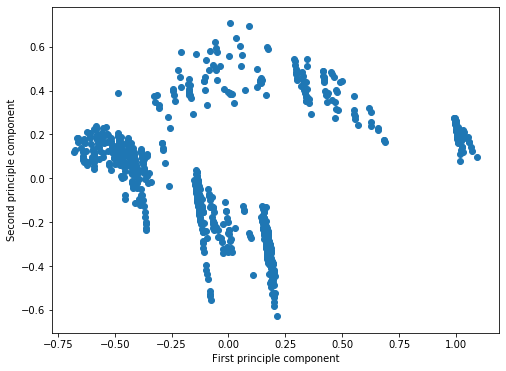

In [100]:
''' To rescale all numerical attributes of the clustering_Belgium_Netherlands_df '''
scaled_clustering_Belgium_Netherlands_df = scale_clustering_attributes_to_df(clustering_Belgium_Netherlands_df)
scaled_clustering_Belgium_Netherlands_arr = scale_clustering_attributes_to_arr(clustering_Belgium_Netherlands_df.drop('country', axis=1))
scaled_clustering_Belgium_Netherlands_df
scaled_clustering_Belgium_Netherlands_arr

''' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'''
x_pca_clustering_Belgium_Netherlands_arr = create_array_two_components(scaled_clustering_Belgium_Netherlands_arr)
x_pca_clustering_Belgium_Netherlands_arr

''' To creata a PCA plot from x_pca_clustering_merged'''
PCA_plot_before_clustering_Belgium_Netherlands = create_PCA_plot_one_argument(x_pca_clustering_Belgium_Netherlands_arr)
PCA_plot_before_clustering_Belgium_Netherlands

In [101]:
''' To split the scaled_clustering_Belgium_Netherlands_df '''
scaled_clustering_df_Belgium_from_Belgium_Netherlands = scaled_clustering_Belgium_Netherlands_df[scaled_clustering_Belgium_Netherlands_df['country'] == 'Belgium']
scaled_clustering_df_Netherlands_from_Belgium_Netherlands = scaled_clustering_Belgium_Netherlands_df[scaled_clustering_Belgium_Netherlands_df['country'] == 'Netherlands']

scaled_clustering_df_Belgium_from_Belgium_Netherlands
scaled_clustering_df_Netherlands_from_Belgium_Netherlands

''' To convert the x_pca_clustering_merged array to a df and to add the country attribute'''
# To convert the x_pca_clustering_merged array to a df
x_pca_clustering_Belgium_Netherlands_df = pd.DataFrame({'Principal component 1': x_pca_clustering_Belgium_Netherlands_arr[:, 0], 'Principal component 2': x_pca_clustering_Belgium_Netherlands_arr[:, 1]})

# To add the country attribute
x_pca_clustering_Belgium_Netherlands_df['country'] = scaled_clustering_Belgium_Netherlands_df['country']
x_pca_clustering_Belgium_Netherlands_df

''' To split the x_pca_clustering_Belgium_Netherlands_df df into two for both the countries '''
x_pca_clustering_df_Belgium_from_Belgium_Netherlands = x_pca_clustering_Belgium_Netherlands_df[x_pca_clustering_Belgium_Netherlands_df['country'] == 'Belgium']
x_pca_clustering_df_Netherlands_from_Belgium_Netherlands = x_pca_clustering_Belgium_Netherlands_df[x_pca_clustering_Belgium_Netherlands_df['country'] == 'Netherlands']
x_pca_clustering_df_Belgium_from_Belgium_Netherlands
x_pca_clustering_df_Netherlands_from_Belgium_Netherlands

''' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'''
# To drop the country attribute
x_pca_clustering_df_Belgium_from_Belgium_Netherlands = x_pca_clustering_df_Belgium_from_Belgium_Netherlands.drop('country', axis=1)
x_pca_clustering_df_Netherlands_from_Belgium_Netherlands = x_pca_clustering_df_Netherlands_from_Belgium_Netherlands.drop('country', axis=1)

# To convert the x_pca_clustering dfs of both countries to an array
x_pca_clustering_arr_Belgium_from_Belgium_Netherlands = x_pca_clustering_df_Belgium_from_Belgium_Netherlands.to_numpy()
x_pca_clustering_arr_Netherlands_from_Belgium_Netherlands = x_pca_clustering_df_Netherlands_from_Belgium_Netherlands.to_numpy()

x_pca_clustering_arr_Belgium_from_Belgium_Netherlands
x_pca_clustering_arr_Netherlands_from_Belgium_Netherlands

' To split the scaled_clustering_Belgium_Netherlands_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.1250,0.150016,0.090563,0.031250,0.016783,Belgium
1,0.1250,0.099861,0.035627,0.046875,0.016860,Belgium
2,0.0625,0.089027,0.063672,0.093750,0.012494,Belgium
3,0.3125,0.235299,0.450163,0.171875,0.079411,Belgium
4,0.1875,0.211292,0.094024,0.125000,0.018519,Belgium
...,...,...,...,...,...,...
568,0.3125,0.235299,0.450163,0.203125,0.065813,Belgium
569,0.4375,0.255575,0.784633,0.781250,0.119997,Belgium
570,0.3750,0.269563,0.691497,0.718750,0.180910,Belgium
571,0.4375,0.269563,0.784633,0.390625,0.207711,Belgium


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
573,0.6875,0.910080,0.471218,0.015625,0.055952,Netherlands
574,1.0000,1.000000,1.000000,0.031250,0.044903,Netherlands
575,1.0000,1.000000,1.000000,0.062500,0.043358,Netherlands
576,0.4375,0.801609,0.049043,0.171875,0.042941,Netherlands
577,1.0000,1.000000,1.000000,0.046875,0.074229,Netherlands
...,...,...,...,...,...,...
763,0.5625,0.820412,0.467939,0.078125,0.064988,Netherlands
764,0.3125,0.613706,0.160425,0.031250,0.049590,Netherlands
765,0.3125,0.463576,0.082983,0.015625,0.018424,Netherlands
766,0.1875,0.613706,0.160425,0.109375,0.042875,Netherlands


' To convert the x_pca_clustering_merged array to a df and to add the country attribute'

,Principal component 1,Principal component 2,country
0,-0.515423,0.184461,Belgium
1,-0.576746,0.177446,Belgium
2,-0.597185,0.124325,Belgium
3,-0.130641,-0.032815,Belgium
4,-0.440388,0.176019,Belgium
...,...,...,...
763,0.336721,0.387504,Netherlands
764,-0.108007,0.442287,Netherlands
765,-0.244044,0.405714,Netherlands
766,-0.172044,0.389923,Netherlands


' To split the x_pca_clustering_Belgium_Netherlands_df df into two for both the countries '

,Principal component 1,Principal component 2,country
0,-0.515423,0.184461,Belgium
1,-0.576746,0.177446,Belgium
2,-0.597185,0.124325,Belgium
3,-0.130641,-0.032815,Belgium
4,-0.440388,0.176019,Belgium
...,...,...,...
568,-0.130446,-0.048479,Belgium
569,0.189884,-0.527104,Belgium
570,0.109456,-0.441063,Belgium
571,0.186941,-0.317712,Belgium


,Principal component 1,Principal component 2,country
573,0.452236,0.485424,Netherlands
574,0.997861,0.254920,Netherlands
575,0.999279,0.238516,Netherlands
576,0.002069,0.559276,Netherlands
577,1.001624,0.244869,Netherlands
...,...,...,...
763,0.336721,0.387504,Netherlands
764,-0.108007,0.442287,Netherlands
765,-0.244044,0.405714,Netherlands
766,-0.172044,0.389923,Netherlands


' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'

array([[-0.51542268,  0.18446052],
       [-0.57674623,  0.17744624],
       [-0.59718493,  0.12432456],
       ...,
       [ 0.10945628, -0.44106297],
       [ 0.18694122, -0.31771235],
       [ 0.09826428, -0.27105415]])

array([[ 0.45223554,  0.48542404],
       [ 0.99786114,  0.2549203 ],
       [ 0.9992791 ,  0.23851579],
       [ 0.00206904,  0.55927564],
       [ 1.00162409,  0.24486867],
       [ 1.01758631,  0.21188373],
       [ 0.45717464,  0.47466018],
       [-0.08702518,  0.49231649],
       [ 0.99842579,  0.22348669],
       [ 1.01016971,  0.16196452],
       [ 1.00445116,  0.18874625],
       [ 0.46616435,  0.34785689],
       [ 0.42093113,  0.45492311],
       [ 1.01549689,  0.20537609],
       [ 0.65786247,  0.22045701],
       [ 0.47155064,  0.31826907],
       [-0.09765219,  0.53770113],
       [-0.26554221,  0.2800567 ],
       [-0.05659404,  0.59550695],
       [ 0.35340871,  0.36185251],
       [ 1.02218104,  0.13137211],
       [ 0.49193427,  0.43806509],
       [ 0.41842638,  0.44866698],
       [ 0.05787107,  0.56357072],
       [-0.32120272,  0.34981837],
       [ 1.00097032,  0.24526457],
       [ 0.09045345,  0.69656717],
       [ 0.55557411,  0.28453168],
       [ 1.00734465,

' To apply the elbow method to get the optimal number of clusters of routes in each railway system'

6

6

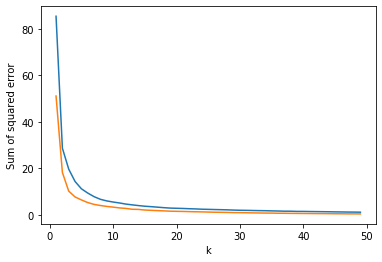

In [102]:
''' To apply the elbow method to get the optimal number of clusters of routes in each railway system'''
optimal_number_clusters_Belgium_from_Belgium_Netherlands = optimal_number_clusters(scaled_clustering_df_Belgium_from_Belgium_Netherlands.drop('country', axis=1))
optimal_number_clusters_Netherlands_from_Belgium_Netherlands = optimal_number_clusters(scaled_clustering_df_Netherlands_from_Belgium_Netherlands.drop('country', axis=1))

optimal_number_clusters_Belgium_from_Belgium_Netherlands
optimal_number_clusters_Netherlands_from_Belgium_Netherlands

In [103]:
''' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'''
km_5D_Belgium_from_Belgium_Netherlands, clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Netherlands = assign_cluster_group(optimal_number_clusters_Belgium_from_Belgium_Netherlands, clustering_df_Belgium.drop('country', axis=1), scaled_clustering_df_Belgium_from_Belgium_Netherlands.drop('country', axis=1), x_pca_clustering_df_Belgium_from_Belgium_Netherlands)
km_5D_Netherlands_from_Belgium_Netherlands, clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands, scaled_clustering_cluster_groups_2D_Netherlands_from_Belgium_Netherlands = assign_cluster_group(optimal_number_clusters_Netherlands_from_Belgium_Netherlands, clustering_df_Netherlands.drop('country', axis=1), scaled_clustering_df_Netherlands_from_Belgium_Netherlands.drop('country', axis=1), x_pca_clustering_df_Netherlands_from_Belgium_Netherlands)

clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands
scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands
scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Netherlands
clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands
scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands
scaled_clustering_cluster_groups_2D_Netherlands_from_Belgium_Netherlands

' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,4,0.052824,0.059701,4,18.856662,2
1,4,0.045197,0.030485,5,18.936973,2
2,3,0.043550,0.045400,8,14.412581,2
3,7,0.065792,0.250941,13,83.752756,4
4,5,0.062142,0.061542,10,20.655690,2
...,...,...,...,...,...,...
568,7,0.065792,0.250941,15,69.662900,4
569,9,0.068876,0.428818,52,125.808981,1
570,8,0.071002,0.379287,48,188.927295,1
571,9,0.071002,0.428818,27,216.698827,5


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,0.1250,0.150016,0.090563,0.031250,0.016783,2
1,0.1250,0.099861,0.035627,0.046875,0.016860,2
2,0.0625,0.089027,0.063672,0.093750,0.012494,2
3,0.3125,0.235299,0.450163,0.171875,0.079411,4
4,0.1875,0.211292,0.094024,0.125000,0.018519,2
...,...,...,...,...,...,...
568,0.3125,0.235299,0.450163,0.203125,0.065813,4
569,0.4375,0.255575,0.784633,0.781250,0.119997,1
570,0.3750,0.269563,0.691497,0.718750,0.180910,1
571,0.4375,0.269563,0.784633,0.390625,0.207711,5


,Principal component 1,Principal component 2,cluster_group
0,-0.515423,0.184461,2
1,-0.576746,0.177446,2
2,-0.597185,0.124325,2
3,-0.130641,-0.032815,4
4,-0.440388,0.176019,2
...,...,...,...
568,-0.130446,-0.048479,4
569,0.189884,-0.527104,1
570,0.109456,-0.441063,1
571,0.186941,-0.317712,5


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,13,0.168401,0.262139,3,59.444891,0
1,18,0.182074,0.543353,4,47.994900,1
2,18,0.182074,0.543353,6,46.394804,1
3,9,0.151906,0.037620,13,45.962746,3
4,18,0.182074,0.543353,5,78.383771,1
...,...,...,...,...,...,...
190,11,0.154765,0.260395,7,68.807951,0
191,7,0.123333,0.096855,4,52.851600,2
192,7,0.100504,0.055670,3,20.557738,2
193,5,0.123333,0.096855,9,45.893449,2


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
573,0.6875,0.910080,0.471218,0.015625,0.055952,0
574,1.0000,1.000000,1.000000,0.031250,0.044903,1
575,1.0000,1.000000,1.000000,0.062500,0.043358,1
576,0.4375,0.801609,0.049043,0.171875,0.042941,3
577,1.0000,1.000000,1.000000,0.046875,0.074229,1
...,...,...,...,...,...,...
763,0.5625,0.820412,0.467939,0.078125,0.064988,0
764,0.3125,0.613706,0.160425,0.031250,0.049590,2
765,0.3125,0.463576,0.082983,0.015625,0.018424,2
766,0.1875,0.613706,0.160425,0.109375,0.042875,2


,Principal component 1,Principal component 2,cluster_group
573,0.452236,0.485424,0
574,0.997861,0.254920,1
575,0.999279,0.238516,1
576,0.002069,0.559276,3
577,1.001624,0.244869,1
...,...,...,...
763,0.336721,0.387504,0
764,-0.108007,0.442287,2
765,-0.244044,0.405714,2
766,-0.172044,0.389923,2


In [104]:
''' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '''
cluster_centroids_5D_Belgium_from_Belgium_Netherlands = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands)
cluster_centroids_5D_Netherlands_from_Belgium_Netherlands = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands)
cluster_centroids_2D_Belgium_from_Belgium_Netherlands = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Netherlands)
cluster_centroids_2D_Netherlands_from_Belgium_Netherlands = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Netherlands_from_Belgium_Netherlands)

cluster_centroids_5D_Belgium_from_Belgium_Netherlands
cluster_centroids_5D_Netherlands_from_Belgium_Netherlands
cluster_centroids_2D_Belgium_from_Belgium_Netherlands
cluster_centroids_2D_Netherlands_from_Belgium_Netherlands

# To compare the 5D centroids of the get_cluster_centroids definition to the 5D centroids of the find_cluster_centroids_in_5D definition
# These centroids values are almost equal. 
#centroidtest_5D_scaled = get_cluster_centroids(km_5D_Belgium_from_Belgium_Netherlands)
#centroidtest_5D_scaled

' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '

array([[0.185     , 0.1553679 , 0.19780645, 0.350625  , 0.07641016],
       [0.35775862, 0.23769822, 0.66678166, 0.7580819 , 0.15861518],
       [0.13922156, 0.12395992, 0.10622771, 0.08953967, 0.02960773],
       [0.43571429, 0.26601112, 0.78197189, 0.2389881 , 0.06286507],
       [0.27224576, 0.22689752, 0.53357264, 0.24086335, 0.06232696],
       [0.42247596, 0.26557254, 0.77398307, 0.47370793, 0.13552797]])

array([[0.61607143, 0.87469754, 0.43176175, 0.11969866, 0.09295692],
       [1.        , 1.        , 1.        , 0.10873724, 0.11703691],
       [0.20703125, 0.56455906, 0.12549432, 0.09082031, 0.03765654],
       [0.38344595, 0.76715499, 0.18191248, 0.08445946, 0.04514601],
       [0.56818182, 0.93700151, 0.77431409, 0.09517045, 0.10575153],
       [0.85625   , 0.9721085 , 0.87941599, 0.18125   , 0.66012748]])

array([[-0.39159334, -0.04121755],
       [ 0.06673463, -0.46716894],
       [-0.50843584,  0.12921821],
       [ 0.16000459, -0.22954088],
       [-0.10364497, -0.12540223],
       [ 0.16688668, -0.35478887]])

array([[ 0.37852523,  0.42289485],
       [ 1.00908465,  0.20957639],
       [-0.21216375,  0.3920959 ],
       [ 0.03172683,  0.50222343],
       [ 0.59977736,  0.27002657],
       [ 0.90017939,  0.17756528]])

' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'

' To make the 2D PCA plot of Netherlands with the Dutch cluster centroids'

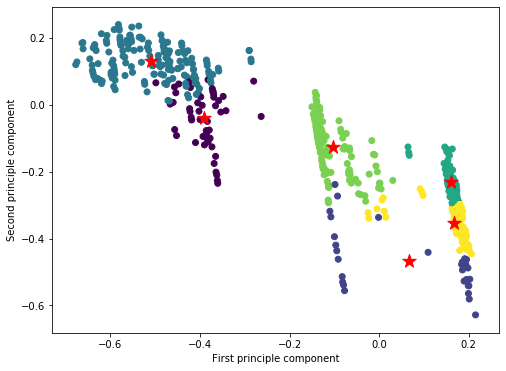

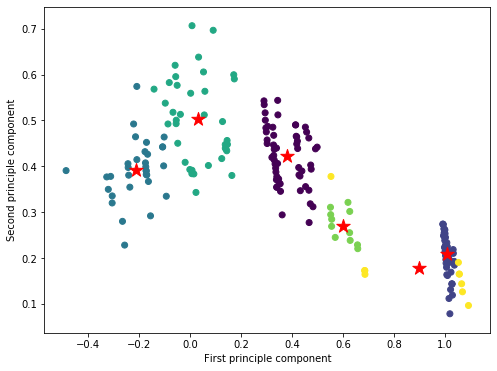

In [105]:
''' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'''
PCA_plot_clustering_Belgium_from_Belgium_Netherlands_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_Belgium_Netherlands, cluster_centroids_2D_Belgium_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands)
PCA_plot_clustering_Belgium_from_Belgium_Netherlands_belgian_centroids

''' To make the 2D PCA plot of Netherlands with the Dutch cluster centroids'''
PCA_plot_clustering_Netherlands_from_Belgium_Netherlands_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_Belgium_Netherlands, cluster_centroids_2D_Netherlands_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands)
PCA_plot_clustering_Netherlands_from_Belgium_Netherlands_dutch_centroids

' To make the 2D PCA plot of Belgium with the Dutch cluster centroids'

' To make the 2D PCA plot of Netherlands with the Belgian cluster centroids'

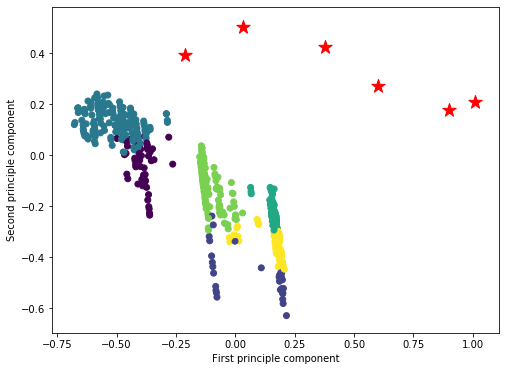

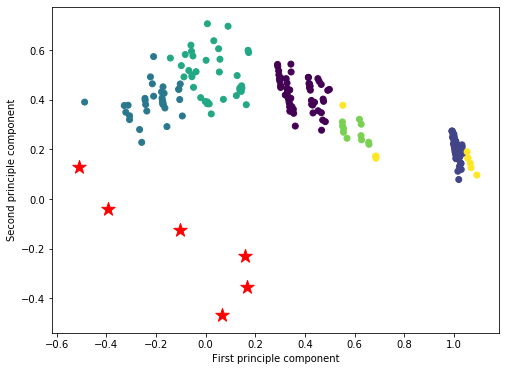

In [106]:
''' To make the 2D PCA plot of Belgium with the Dutch cluster centroids'''
PCA_plot_clustering_Belgium_from_Belgium_Netherlands_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_Belgium_Netherlands, cluster_centroids_2D_Netherlands_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands)
PCA_plot_clustering_Belgium_from_Belgium_Netherlands_dutch_centroids

''' To make the 2D PCA plot of Netherlands with the Belgian cluster centroids'''
PCA_plot_clustering_Netherlands_from_Belgium_Netherlands_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_Belgium_Netherlands, cluster_centroids_2D_Belgium_from_Belgium_Netherlands, scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands)
PCA_plot_clustering_Netherlands_from_Belgium_Netherlands_belgian_centroids

### Actual clustering of Belgium and Switzerland

In [107]:
''' To create the clustering_dfs that contain the interesting attributes for clustering'''
clustering_df_Belgium = select_clustering_attributes(route_characteristics_Belgium)
clustering_df_Switzerland = select_clustering_attributes(route_characteristics_Switzerland)

''' To add a country attribute to the clustering_dfs'''
clustering_df_Belgium.loc[:,'country'] = 'Belgium'
clustering_df_Switzerland.loc[:,'country'] = 'Switzerland'

''' To merge the two clustering_dfs'''
clustering_Belgium_Switzerland_df = clustering_df_Belgium.append(clustering_df_Switzerland)

# To reset the index
clustering_Belgium_Switzerland_df = clustering_Belgium_Switzerland_df.reset_index(drop=True)
clustering_Belgium_Switzerland_df

' To create the clustering_dfs that contain the interesting attributes for clustering'

' To add a country attribute to the clustering_dfs'

/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


' To merge the two clustering_dfs'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,4,0.052824,0.059701,4,18.856662,Belgium
1,4,0.045197,0.030485,5,18.936973,Belgium
2,3,0.043550,0.045400,8,14.412581,Belgium
3,7,0.065792,0.250941,13,83.752756,Belgium
4,5,0.062142,0.061542,10,20.655690,Belgium
...,...,...,...,...,...,...
2491,11,0.103136,0.036953,3,177.110629,Switzerland
2492,11,0.103136,0.036953,3,129.437931,Switzerland
2493,11,0.103136,0.036953,4,129.465746,Switzerland
2494,11,0.103136,0.036953,5,200.296819,Switzerland


' To rescale all numerical attributes of the clustering_Belgium_Switzerland_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.125000,0.384696,0.137894,0.031250,0.024694,Belgium
1,0.125000,0.328595,0.070414,0.046875,0.024803,Belgium
2,0.083333,0.316478,0.104863,0.093750,0.018708,Belgium
3,0.250000,0.480090,0.579614,0.171875,0.112106,Belgium
4,0.166667,0.453237,0.142146,0.125000,0.027118,Belgium
...,...,...,...,...,...,...
2491,0.416667,0.754786,0.085353,0.015625,0.237854,Switzerland
2492,0.416667,0.754786,0.085353,0.015625,0.173641,Switzerland
2493,0.416667,0.754786,0.085353,0.031250,0.173679,Switzerland
2494,0.416667,0.754786,0.085353,0.046875,0.269085,Switzerland


array([[0.125     , 0.38469616, 0.13789447, 0.03125   , 0.02469433],
       [0.125     , 0.32859543, 0.07041379, 0.046875  , 0.0248025 ],
       [0.08333333, 0.31647797, 0.10486278, 0.09375   , 0.01870839],
       ...,
       [0.41666667, 0.75478594, 0.08535314, 0.03125   , 0.17367886],
       [0.41666667, 0.75478594, 0.08535314, 0.046875  , 0.26908454],
       [0.41666667, 0.75478594, 0.08535314, 0.015625  , 0.14886357]])

' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'

array([[ 0.57276037,  0.13524926],
       [ 0.63920958,  0.1283177 ],
       [ 0.64290943,  0.18844932],
       ...,
       [ 0.29224986, -0.22364371],
       [ 0.28495508, -0.21226967],
       [ 0.29466861, -0.22992512]])

' To creata a PCA plot from x_pca_clustering_merged'

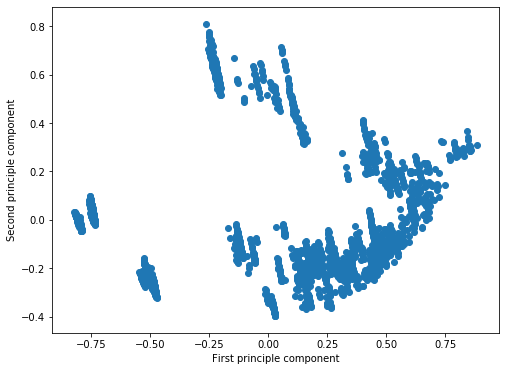

In [108]:
''' To rescale all numerical attributes of the clustering_Belgium_Switzerland_df '''
scaled_clustering_Belgium_Switzerland_df = scale_clustering_attributes_to_df(clustering_Belgium_Switzerland_df)
scaled_clustering_Belgium_Switzerland_arr = scale_clustering_attributes_to_arr(clustering_Belgium_Switzerland_df.drop('country', axis=1))
scaled_clustering_Belgium_Switzerland_df
scaled_clustering_Belgium_Switzerland_arr

''' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'''
x_pca_clustering_Belgium_Switzerland_arr = create_array_two_components(scaled_clustering_Belgium_Switzerland_arr)
x_pca_clustering_Belgium_Switzerland_arr

''' To creata a PCA plot from x_pca_clustering_merged'''
PCA_plot_before_clustering_Belgium_Switzerland = create_PCA_plot_one_argument(x_pca_clustering_Belgium_Switzerland_arr)
PCA_plot_before_clustering_Belgium_Switzerland

In [109]:
''' To split the scaled_clustering_Belgium_Switzerland_df '''
scaled_clustering_df_Belgium_from_Belgium_Switzerland = scaled_clustering_Belgium_Switzerland_df[scaled_clustering_Belgium_Switzerland_df['country'] == 'Belgium']
scaled_clustering_df_Switzerland_from_Belgium_Switzerland = scaled_clustering_Belgium_Switzerland_df[scaled_clustering_Belgium_Switzerland_df['country'] == 'Switzerland']

scaled_clustering_df_Belgium_from_Belgium_Switzerland
scaled_clustering_df_Switzerland_from_Belgium_Switzerland

''' To convert the x_pca_clustering_merged array to a df and to add the country attribute'''
# To convert the x_pca_clustering_merged array to a df
x_pca_clustering_Belgium_Switzerland_df = pd.DataFrame({'Principal component 1': x_pca_clustering_Belgium_Switzerland_arr[:, 0], 'Principal component 2': x_pca_clustering_Belgium_Switzerland_arr[:, 1]})

# To add the country attribute
x_pca_clustering_Belgium_Switzerland_df['country'] = scaled_clustering_Belgium_Switzerland_df['country']
x_pca_clustering_Belgium_Switzerland_df

''' To split the x_pca_clustering_Belgium_Switzerland_df df into two for both the countries '''
x_pca_clustering_df_Belgium_from_Belgium_Switzerland = x_pca_clustering_Belgium_Switzerland_df[x_pca_clustering_Belgium_Switzerland_df['country'] == 'Belgium']
x_pca_clustering_df_Switzerland_from_Belgium_Switzerland = x_pca_clustering_Belgium_Switzerland_df[x_pca_clustering_Belgium_Switzerland_df['country'] == 'Switzerland']
x_pca_clustering_df_Belgium_from_Belgium_Switzerland
x_pca_clustering_df_Switzerland_from_Belgium_Switzerland

''' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'''
# To drop the country attribute
x_pca_clustering_df_Belgium_from_Belgium_Switzerland = x_pca_clustering_df_Belgium_from_Belgium_Switzerland.drop('country', axis=1)
x_pca_clustering_df_Switzerland_from_Belgium_Switzerland = x_pca_clustering_df_Switzerland_from_Belgium_Switzerland.drop('country', axis=1)

# To convert the x_pca_clustering dfs of both countries to an array
x_pca_clustering_arr_Belgium_from_Belgium_Switzerland = x_pca_clustering_df_Belgium_from_Belgium_Switzerland.to_numpy()
x_pca_clustering_arr_Switzerland_from_Belgium_Switzerland = x_pca_clustering_df_Switzerland_from_Belgium_Switzerland.to_numpy()

x_pca_clustering_arr_Belgium_from_Belgium_Switzerland
x_pca_clustering_arr_Switzerland_from_Belgium_Switzerland

' To split the scaled_clustering_Belgium_Switzerland_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.125000,0.384696,0.137894,0.031250,0.024694,Belgium
1,0.125000,0.328595,0.070414,0.046875,0.024803,Belgium
2,0.083333,0.316478,0.104863,0.093750,0.018708,Belgium
3,0.250000,0.480090,0.579614,0.171875,0.112106,Belgium
4,0.166667,0.453237,0.142146,0.125000,0.027118,Belgium
...,...,...,...,...,...,...
568,0.250000,0.480090,0.579614,0.203125,0.093128,Belgium
569,0.333333,0.502770,0.990465,0.781250,0.168753,Belgium
570,0.291667,0.518415,0.876060,0.718750,0.253770,Belgium
571,0.333333,0.518415,0.990465,0.390625,0.291177,Belgium


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
573,0.041667,0.486414,0.006660,0.031250,0.003767,Switzerland
574,0.041667,0.003872,0.000001,0.015625,0.005427,Switzerland
575,0.916667,1.000000,1.000000,0.031250,0.106026,Switzerland
576,0.916667,1.000000,1.000000,0.078125,0.244988,Switzerland
577,0.916667,1.000000,1.000000,0.015625,0.102567,Switzerland
...,...,...,...,...,...,...
2491,0.416667,0.754786,0.085353,0.015625,0.237854,Switzerland
2492,0.416667,0.754786,0.085353,0.015625,0.173641,Switzerland
2493,0.416667,0.754786,0.085353,0.031250,0.173679,Switzerland
2494,0.416667,0.754786,0.085353,0.046875,0.269085,Switzerland


' To convert the x_pca_clustering_merged array to a df and to add the country attribute'

,Principal component 1,Principal component 2,country
0,0.572760,0.135249,Belgium
1,0.639210,0.128318,Belgium
2,0.642909,0.188449,Belgium
3,0.139026,0.353584,Belgium
4,0.516006,0.108257,Belgium
...,...,...,...
2491,0.288522,-0.223505,Switzerland
2492,0.292957,-0.228138,Switzerland
2493,0.292250,-0.223644,Switzerland
2494,0.284955,-0.212270,Switzerland


' To split the x_pca_clustering_Belgium_Switzerland_df df into two for both the countries '

,Principal component 1,Principal component 2,country
0,0.572760,0.135249,Belgium
1,0.639210,0.128318,Belgium
2,0.642909,0.188449,Belgium
3,0.139026,0.353584,Belgium
4,0.516006,0.108257,Belgium
...,...,...,...
568,0.138928,0.361197,Belgium
569,-0.241129,0.743990,Belgium
570,-0.143430,0.669243,Belgium
571,-0.237420,0.631787,Belgium


,Principal component 1,Principal component 2,country
573,0.682324,0.030420,Switzerland
574,0.855735,0.291893,Switzerland
575,-0.739642,-0.006671,Switzerland
576,-0.751355,0.016827,Switzerland
577,-0.738698,-0.011412,Switzerland
...,...,...,...
2491,0.288522,-0.223505,Switzerland
2492,0.292957,-0.228138,Switzerland
2493,0.292250,-0.223644,Switzerland
2494,0.284955,-0.212270,Switzerland


' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'

array([[ 0.57276037,  0.13524926],
       [ 0.63920958,  0.1283177 ],
       [ 0.64290943,  0.18844932],
       ...,
       [-0.14342957,  0.66924292],
       [-0.23742022,  0.63178721],
       [-0.13370788,  0.58023005]])

array([[ 0.68232421,  0.03042047],
       [ 0.85573549,  0.29189318],
       [-0.73964201, -0.00667134],
       ...,
       [ 0.29224986, -0.22364371],
       [ 0.28495508, -0.21226967],
       [ 0.29466861, -0.22992512]])

' To apply the elbow method to get the optimal number of clusters of routes in each railway system'

5

6

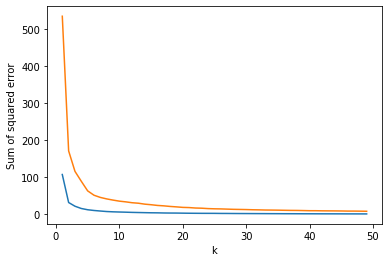

In [110]:
''' To apply the elbow method to get the optimal number of clusters of routes in each railway system'''
optimal_number_clusters_Belgium_from_Belgium_Switzerland = optimal_number_clusters(scaled_clustering_df_Belgium_from_Belgium_Switzerland.drop('country', axis=1))
optimal_number_clusters_Switzerland_from_Belgium_Switzerland = optimal_number_clusters(scaled_clustering_df_Switzerland_from_Belgium_Switzerland.drop('country', axis=1))

optimal_number_clusters_Belgium_from_Belgium_Switzerland
optimal_number_clusters_Switzerland_from_Belgium_Switzerland

In [111]:
''' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'''
km_5D_Belgium_from_Belgium_Switzerland, clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland, scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Switzerland = assign_cluster_group(optimal_number_clusters_Belgium_from_Belgium_Switzerland, clustering_df_Belgium.drop('country', axis=1), scaled_clustering_df_Belgium_from_Belgium_Switzerland.drop('country', axis=1), x_pca_clustering_df_Belgium_from_Belgium_Switzerland)
km_5D_Switzerland_from_Belgium_Switzerland, clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland, scaled_clustering_cluster_groups_2D_Switzerland_from_Belgium_Switzerland = assign_cluster_group(optimal_number_clusters_Switzerland_from_Belgium_Switzerland, clustering_df_Switzerland.drop('country', axis=1), scaled_clustering_df_Switzerland_from_Belgium_Switzerland.drop('country', axis=1), x_pca_clustering_df_Switzerland_from_Belgium_Switzerland)

clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland
scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland
scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Switzerland
clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland
scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland
scaled_clustering_cluster_groups_2D_Switzerland_from_Belgium_Switzerland

' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,4,0.052824,0.059701,4,18.856662,1
1,4,0.045197,0.030485,5,18.936973,1
2,3,0.043550,0.045400,8,14.412581,1
3,7,0.065792,0.250941,13,83.752756,3
4,5,0.062142,0.061542,10,20.655690,1
...,...,...,...,...,...,...
568,7,0.065792,0.250941,15,69.662900,3
569,9,0.068876,0.428818,52,125.808981,0
570,8,0.071002,0.379287,48,188.927295,0
571,9,0.071002,0.428818,27,216.698827,2


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,0.125000,0.384696,0.137894,0.031250,0.024694,1
1,0.125000,0.328595,0.070414,0.046875,0.024803,1
2,0.083333,0.316478,0.104863,0.093750,0.018708,1
3,0.250000,0.480090,0.579614,0.171875,0.112106,3
4,0.166667,0.453237,0.142146,0.125000,0.027118,1
...,...,...,...,...,...,...
568,0.250000,0.480090,0.579614,0.203125,0.093128,3
569,0.333333,0.502770,0.990465,0.781250,0.168753,0
570,0.291667,0.518415,0.876060,0.718750,0.253770,0
571,0.333333,0.518415,0.990465,0.390625,0.291177,2


,Principal component 1,Principal component 2,cluster_group
0,0.572760,0.135249,1
1,0.639210,0.128318,1
2,0.642909,0.188449,1
3,0.139026,0.353584,3
4,0.516006,0.108257,1
...,...,...,...
568,0.138928,0.361197,3
569,-0.241129,0.743990,0
570,-0.143430,0.669243,0
571,-0.237420,0.631787,2


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,2,0.066652,2.883512e-03,4,3.320147,4
1,2,0.001053,5.543084e-07,3,4.552323,3
2,23,0.136472,4.329460e-01,4,79.239036,1
3,23,0.136472,4.329460e-01,7,182.406957,1
4,23,0.136472,4.329460e-01,3,76.670926,1
...,...,...,...,...,...,...
1918,11,0.103136,3.695330e-02,3,177.110629,2
1919,11,0.103136,3.695330e-02,3,129.437931,2
1920,11,0.103136,3.695330e-02,4,129.465746,2
1921,11,0.103136,3.695330e-02,5,200.296819,2


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
573,0.041667,0.486414,0.006660,0.031250,0.003767,4
574,0.041667,0.003872,0.000001,0.015625,0.005427,3
575,0.916667,1.000000,1.000000,0.031250,0.106026,1
576,0.916667,1.000000,1.000000,0.078125,0.244988,1
577,0.916667,1.000000,1.000000,0.015625,0.102567,1
...,...,...,...,...,...,...
2491,0.416667,0.754786,0.085353,0.015625,0.237854,2
2492,0.416667,0.754786,0.085353,0.015625,0.173641,2
2493,0.416667,0.754786,0.085353,0.031250,0.173679,2
2494,0.416667,0.754786,0.085353,0.046875,0.269085,2


,Principal component 1,Principal component 2,cluster_group
573,0.682324,0.030420,4
574,0.855735,0.291893,3
575,-0.739642,-0.006671,1
576,-0.751355,0.016827,1
577,-0.738698,-0.011412,1
...,...,...,...
2491,0.288522,-0.223505,2
2492,0.292957,-0.228138,2
2493,0.292250,-0.223644,2
2494,0.284955,-0.212270,2


In [112]:
''' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '''
cluster_centroids_5D_Belgium_from_Belgium_Switzerland = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland)
cluster_centroids_5D_Switzerland_from_Belgium_Switzerland = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland)
cluster_centroids_2D_Belgium_from_Belgium_Switzerland = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Belgium_from_Belgium_Switzerland)
cluster_centroids_2D_Switzerland_from_Belgium_Switzerland = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Switzerland_from_Belgium_Switzerland)

cluster_centroids_5D_Belgium_from_Belgium_Switzerland
cluster_centroids_5D_Switzerland_from_Belgium_Switzerland
cluster_centroids_2D_Belgium_from_Belgium_Switzerland
cluster_centroids_2D_Switzerland_from_Belgium_Switzerland

# To compare the 5D centroids of the get_cluster_centroids definition to the 5D centroids of the find_cluster_centroids_in_5D definition
# These centroids values are almost equal. 
#centroidtest_5D_scaled = get_cluster_centroids(km_5D_Belgium_from_Belgium_Switzerland)
#centroidtest_5D_scaled

' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '

array([[0.30539216, 0.50380565, 0.92827501, 0.60808824, 0.21994346],
       [0.13448104, 0.35555162, 0.15713666, 0.08953967, 0.0425945 ],
       [0.32336401, 0.51390193, 0.97800486, 0.2952454 , 0.11013806],
       [0.22492284, 0.46685337, 0.66662019, 0.23104745, 0.08680704],
       [0.165     , 0.39068298, 0.26962863, 0.350625  , 0.10791782]])

array([[0.59680763, 0.84826607, 0.43402295, 0.14287935, 0.13085635],
       [0.93891916, 1.        , 1.        , 0.14237057, 0.12331949],
       [0.46880379, 0.83790604, 0.15532345, 0.14487414, 0.06631831],
       [0.10245098, 0.13565283, 0.00728195, 0.08382353, 0.0440645 ],
       [0.22548426, 0.70270225, 0.05355591, 0.09870611, 0.03467297],
       [1.        , 0.97046417, 0.60195442, 0.1360394 , 0.10155984]])

array([[-0.17624884,  0.67023351],
       [ 0.55967446,  0.17762089],
       [-0.20415318,  0.590344  ],
       [ 0.0966582 ,  0.44250227],
       [ 0.43311041,  0.29559783]])

array([[-0.09857538, -0.10544354],
       [-0.75945478,  0.0166617 ],
       [ 0.18432877, -0.22392973],
       [ 0.76177105,  0.21823075],
       [ 0.45629813, -0.12065103],
       [-0.5038596 , -0.24988045]])

' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'

' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'

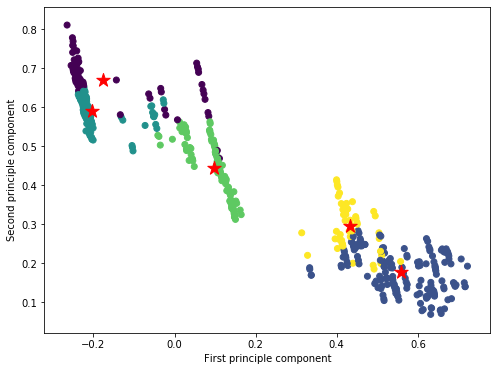

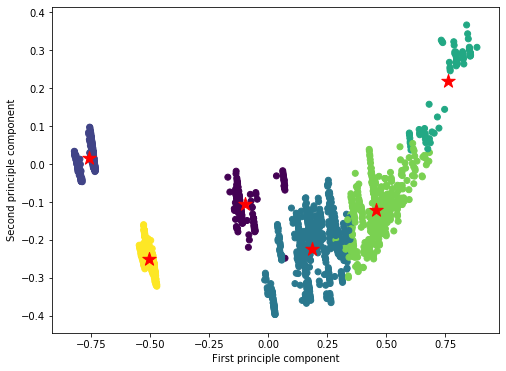

In [113]:
''' To make the 2D PCA plot of Belgium with the Belgian cluster centroids'''
PCA_plot_clustering_Belgium_from_Belgium_Switzerland_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_Belgium_Switzerland, cluster_centroids_2D_Belgium_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland)
PCA_plot_clustering_Belgium_from_Belgium_Switzerland_belgian_centroids

''' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'''
PCA_plot_clustering_Switzerland_from_Belgium_Switzerland_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_Belgium_Switzerland, cluster_centroids_2D_Switzerland_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland)
PCA_plot_clustering_Switzerland_from_Belgium_Switzerland_swiss_centroids

' To make the 2D PCA plot of Belgium with the Swiss cluster centroids'

' To make the 2D PCA plot of Switzerland with the Belgian cluster centroids'

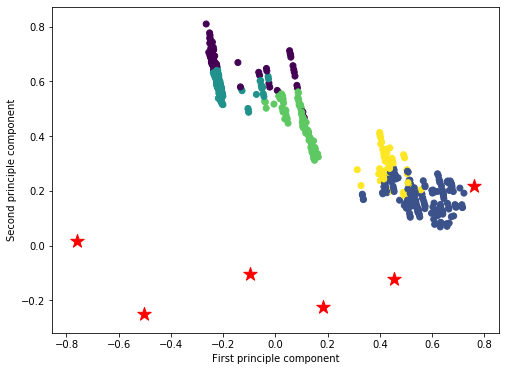

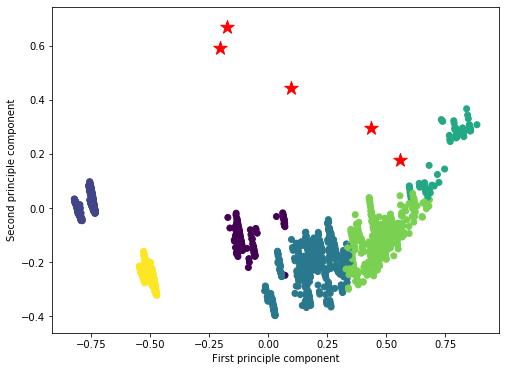

In [114]:
''' To make the 2D PCA plot of Belgium with the Swiss cluster centroids'''
PCA_plot_clustering_Belgium_from_Belgium_Switzerland_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Belgium_from_Belgium_Switzerland, cluster_centroids_2D_Switzerland_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland)
PCA_plot_clustering_Belgium_from_Belgium_Switzerland_swiss_centroids

''' To make the 2D PCA plot of Switzerland with the Belgian cluster centroids'''
PCA_plot_clustering_Switzerland_from_Belgium_Switzerland_belgian_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_Belgium_Switzerland, cluster_centroids_2D_Belgium_from_Belgium_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland)
PCA_plot_clustering_Switzerland_from_Belgium_Switzerland_belgian_centroids

### Actual clustering of the Netherlands and Switzerland

In [115]:
''' To create the clustering_dfs that contain the interesting attributes for clustering'''
clustering_df_Netherlands = select_clustering_attributes(route_characteristics_Netherlands)
clustering_df_Switzerland = select_clustering_attributes(route_characteristics_Switzerland)

''' To add a country attribute to the clustering_dfs'''
clustering_df_Netherlands.loc[:,'country'] = 'Netherlands'
clustering_df_Switzerland.loc[:,'country'] = 'Switzerland'

''' To merge the two clustering_dfs'''
clustering_Netherlands_Switzerland_df = clustering_df_Netherlands.append(clustering_df_Switzerland)

# To reset the index
clustering_Netherlands_Switzerland_df = clustering_Netherlands_Switzerland_df.reset_index(drop=True)
clustering_Netherlands_Switzerland_df

' To create the clustering_dfs that contain the interesting attributes for clustering'

' To add a country attribute to the clustering_dfs'

/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


' To merge the two clustering_dfs'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,13,0.168401,0.262139,3,59.444891,Netherlands
1,18,0.182074,0.543353,4,47.994900,Netherlands
2,18,0.182074,0.543353,6,46.394804,Netherlands
3,9,0.151906,0.037620,13,45.962746,Netherlands
4,18,0.182074,0.543353,5,78.383771,Netherlands
...,...,...,...,...,...,...
2113,11,0.103136,0.036953,3,177.110629,Switzerland
2114,11,0.103136,0.036953,3,129.437931,Switzerland
2115,11,0.103136,0.036953,4,129.465746,Switzerland
2116,11,0.103136,0.036953,5,200.296819,Switzerland


' To rescale all numerical attributes of the clustering_Netherlands_Switzerland_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.500000,0.924685,0.482446,0.028571,0.056811,Netherlands
1,0.708333,1.000000,1.000000,0.057143,0.045771,Netherlands
2,0.708333,1.000000,1.000000,0.114286,0.044228,Netherlands
3,0.333333,0.833831,0.069237,0.314286,0.043812,Netherlands
4,0.708333,1.000000,1.000000,0.085714,0.075071,Netherlands
...,...,...,...,...,...,...
2113,0.416667,0.565194,0.068010,0.028571,0.170261,Switzerland
2114,0.416667,0.565194,0.068010,0.028571,0.124296,Switzerland
2115,0.416667,0.565194,0.068010,0.057143,0.124323,Switzerland
2116,0.416667,0.565194,0.068010,0.085714,0.192617,Switzerland


array([[0.5       , 0.92468476, 0.48244641, 0.02857143, 0.05681087],
       [0.70833333, 1.        , 1.        , 0.05714286, 0.04577108],
       [0.70833333, 1.        , 1.        , 0.11428571, 0.04422831],
       ...,
       [0.41666667, 0.56519424, 0.06800973, 0.05714286, 0.12432317],
       [0.41666667, 0.56519424, 0.06800973, 0.08571429, 0.19261666],
       [0.41666667, 0.56519424, 0.06800973, 0.02857143, 0.10655983]])

' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'

array([[-0.12439309, -0.22126707],
       [-0.63476115, -0.24677168],
       [-0.63819297, -0.19036624],
       ...,
       [ 0.30348734, -0.14320722],
       [ 0.29721472, -0.10813443],
       [ 0.30642611, -0.17325363]])

' To creata a PCA plot from x_pca_clustering_merged'

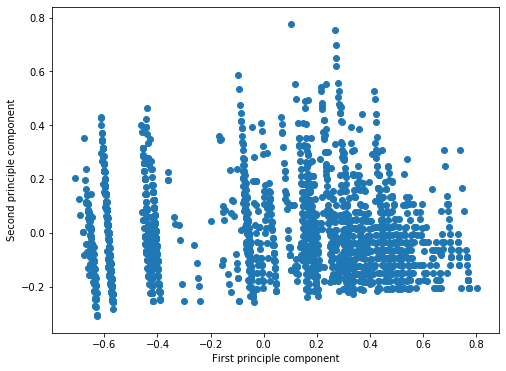

In [116]:
''' To rescale all numerical attributes of the clustering_Netherlands_Switzerland_df '''
scaled_clustering_Netherlands_Switzerland_df = scale_clustering_attributes_to_df(clustering_Netherlands_Switzerland_df)
scaled_clustering_Netherlands_Switzerland_arr = scale_clustering_attributes_to_arr(clustering_Netherlands_Switzerland_df.drop('country', axis=1))
scaled_clustering_Netherlands_Switzerland_df
scaled_clustering_Netherlands_Switzerland_arr

''' To apply PCA and to go from an array of 5 dimensions to an array of 2 dimensions'''
x_pca_clustering_Netherlands_Switzerland_arr = create_array_two_components(scaled_clustering_Netherlands_Switzerland_arr)
x_pca_clustering_Netherlands_Switzerland_arr

''' To creata a PCA plot from x_pca_clustering_merged'''
PCA_plot_before_clustering_Netherlands_Switzerland = create_PCA_plot_one_argument(x_pca_clustering_Netherlands_Switzerland_arr)
PCA_plot_before_clustering_Netherlands_Switzerland

In [117]:
''' To split the scaled_clustering_Netherlands_Switzerland_df '''
scaled_clustering_df_Netherlands_from_Netherlands_Switzerland = scaled_clustering_Netherlands_Switzerland_df[scaled_clustering_Netherlands_Switzerland_df['country'] == 'Netherlands']
scaled_clustering_df_Switzerland_from_Netherlands_Switzerland = scaled_clustering_Netherlands_Switzerland_df[scaled_clustering_Netherlands_Switzerland_df['country'] == 'Switzerland']

scaled_clustering_df_Netherlands_from_Netherlands_Switzerland
scaled_clustering_df_Switzerland_from_Netherlands_Switzerland

''' To convert the x_pca_clustering_merged array to a df and to add the country attribute'''
# To convert the x_pca_clustering_merged array to a df
x_pca_clustering_Netherlands_Switzerland_df = pd.DataFrame({'Principal component 1': x_pca_clustering_Netherlands_Switzerland_arr[:, 0], 'Principal component 2': x_pca_clustering_Netherlands_Switzerland_arr[:, 1]})

# To add the country attribute
x_pca_clustering_Netherlands_Switzerland_df['country'] = scaled_clustering_Netherlands_Switzerland_df['country']
x_pca_clustering_Netherlands_Switzerland_df

''' To split the x_pca_clustering_Netherlands_Switzerland_df df into two for both the countries '''
x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland = x_pca_clustering_Netherlands_Switzerland_df[x_pca_clustering_Netherlands_Switzerland_df['country'] == 'Netherlands']
x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland = x_pca_clustering_Netherlands_Switzerland_df[x_pca_clustering_Netherlands_Switzerland_df['country'] == 'Switzerland']
x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland
x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland

''' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'''
# To drop the country attribute
x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland = x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland.drop('country', axis=1)
x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland = x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland.drop('country', axis=1)

# To convert the x_pca_clustering dfs of both countries to an array
x_pca_clustering_arr_Netherlands_from_Netherlands_Switzerland = x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland.to_numpy()
x_pca_clustering_arr_Switzerland_from_Netherlands_Switzerland = x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland.to_numpy()

x_pca_clustering_arr_Netherlands_from_Netherlands_Switzerland
x_pca_clustering_arr_Switzerland_from_Netherlands_Switzerland

' To split the scaled_clustering_Netherlands_Switzerland_df '

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
0,0.500000,0.924685,0.482446,0.028571,0.056811,Netherlands
1,0.708333,1.000000,1.000000,0.057143,0.045771,Netherlands
2,0.708333,1.000000,1.000000,0.114286,0.044228,Netherlands
3,0.333333,0.833831,0.069237,0.314286,0.043812,Netherlands
4,0.708333,1.000000,1.000000,0.085714,0.075071,Netherlands
...,...,...,...,...,...,...
190,0.416667,0.849580,0.479238,0.142857,0.065838,Netherlands
191,0.250000,0.676446,0.178254,0.057143,0.050454,Netherlands
192,0.250000,0.550700,0.102456,0.028571,0.019317,Netherlands
193,0.166667,0.676446,0.178254,0.200000,0.043745,Netherlands


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,country
195,0.041667,0.364233,0.005307,0.057143,0.002697,Switzerland
196,0.041667,0.002899,0.000001,0.028571,0.003885,Switzerland
197,0.916667,0.748814,0.796804,0.057143,0.075896,Switzerland
198,0.916667,0.748814,0.796804,0.142857,0.175368,Switzerland
199,0.916667,0.748814,0.796804,0.028571,0.073420,Switzerland
...,...,...,...,...,...,...
2113,0.416667,0.565194,0.068010,0.028571,0.170261,Switzerland
2114,0.416667,0.565194,0.068010,0.028571,0.124296,Switzerland
2115,0.416667,0.565194,0.068010,0.057143,0.124323,Switzerland
2116,0.416667,0.565194,0.068010,0.085714,0.192617,Switzerland


' To convert the x_pca_clustering_merged array to a df and to add the country attribute'

,Principal component 1,Principal component 2,country
0,-0.124393,-0.221267,Netherlands
1,-0.634761,-0.246772,Netherlands
2,-0.638193,-0.190366,Netherlands
3,0.274228,0.102373,Netherlands
4,-0.638461,-0.215578,Netherlands
...,...,...,...
2113,0.302223,-0.166917,Switzerland
2114,0.305256,-0.171489,Switzerland
2115,0.303487,-0.143207,Switzerland
2116,0.297215,-0.108134,Switzerland


' To split the x_pca_clustering_Netherlands_Switzerland_df df into two for both the countries '

,Principal component 1,Principal component 2,country
0,-0.124393,-0.221267,Netherlands
1,-0.634761,-0.246772,Netherlands
2,-0.638193,-0.190366,Netherlands
3,0.274228,0.102373,Netherlands
4,-0.638461,-0.215578,Netherlands
...,...,...,...
190,-0.052008,-0.106882,Netherlands
191,0.317657,-0.162372,Netherlands
192,0.407164,-0.185699,Netherlands
193,0.366248,-0.021785,Netherlands


,Principal component 1,Principal component 2,country
195,0.665819,-0.149051,Switzerland
196,0.771709,-0.175784,Switzerland
197,-0.573433,-0.222051,Switzerland
198,-0.585296,-0.127318,Switzerland
199,-0.571503,-0.250577,Switzerland
...,...,...,...
2113,0.302223,-0.166917,Switzerland
2114,0.305256,-0.171489,Switzerland
2115,0.303487,-0.143207,Switzerland
2116,0.297215,-0.108134,Switzerland


' To drop the country attribute and to convert the x_pca_clustering dfs of both countries to an array'

array([[-1.24393093e-01, -2.21267065e-01],
       [-6.34761146e-01, -2.46771676e-01],
       [-6.38192966e-01, -1.90366243e-01],
       [ 2.74228110e-01,  1.02372994e-01],
       [-6.38461091e-01, -2.15577661e-01],
       [-6.52597032e-01, -1.17418130e-01],
       [-1.28857133e-01, -1.88921038e-01],
       [ 3.22141862e-01, -7.22211404e-02],
       [-6.40149241e-01, -1.36185465e-01],
       [-6.56565995e-01,  6.78754753e-02],
       [-6.49084938e-01, -2.02505933e-02],
       [-1.53960638e-01,  9.76685928e-02],
       [-1.01188923e-01, -1.36520071e-01],
       [-6.52494941e-01, -9.19563852e-02],
       [-3.36752081e-01,  5.92002788e-02],
       [-1.62047646e-01,  3.47817428e-01],
       [ 3.42475254e-01, -9.91580898e-02],
       [ 4.19795580e-01,  1.19610325e-01],
       [ 3.27371575e-01, -1.29900712e-01],
       [-6.53596599e-02, -3.55200384e-02],
       [-6.68135205e-01,  1.62165187e-01],
       [-1.53949648e-01, -9.98581229e-02],
       [-1.00817008e-01, -1.11465135e-01],
       [ 2.

array([[ 0.66581938, -0.14905061],
       [ 0.77170869, -0.17578447],
       [-0.57343281, -0.22205095],
       ...,
       [ 0.30348734, -0.14320722],
       [ 0.29721472, -0.10813443],
       [ 0.30642611, -0.17325363]])

' To apply the elbow method to get the optimal number of clusters of routes in each railway system'

6

6

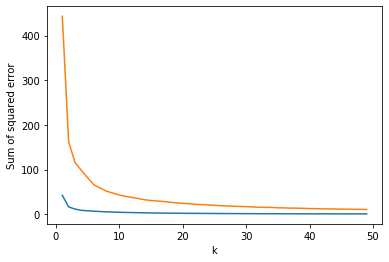

In [118]:
''' To apply the elbow method to get the optimal number of clusters of routes in each railway system'''
optimal_number_clusters_Netherlands_from_Netherlands_Switzerland = optimal_number_clusters(scaled_clustering_df_Netherlands_from_Netherlands_Switzerland.drop('country', axis=1))
optimal_number_clusters_Switzerland_from_Netherlands_Switzerland = optimal_number_clusters(scaled_clustering_df_Switzerland_from_Netherlands_Switzerland.drop('country', axis=1))

optimal_number_clusters_Netherlands_from_Netherlands_Switzerland
optimal_number_clusters_Switzerland_from_Netherlands_Switzerland

In [119]:
''' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'''
km_5D_Netherlands_from_Netherlands_Switzerland, clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_2D_Netherlands_from_Netherlands_Switzerland = assign_cluster_group(optimal_number_clusters_Netherlands_from_Netherlands_Switzerland, clustering_df_Netherlands.drop('country', axis=1), scaled_clustering_df_Netherlands_from_Netherlands_Switzerland.drop('country', axis=1), x_pca_clustering_df_Netherlands_from_Netherlands_Switzerland)
km_5D_Switzerland_from_Netherlands_Switzerland, clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_2D_Switzerland_from_Netherlands_Switzerland = assign_cluster_group(optimal_number_clusters_Switzerland_from_Netherlands_Switzerland, clustering_df_Switzerland.drop('country', axis=1), scaled_clustering_df_Switzerland_from_Netherlands_Switzerland.drop('country', axis=1), x_pca_clustering_df_Switzerland_from_Netherlands_Switzerland)

clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland
scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland
scaled_clustering_cluster_groups_2D_Netherlands_from_Netherlands_Switzerland
clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland
scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland
scaled_clustering_cluster_groups_2D_Switzerland_from_Netherlands_Switzerland

' To assign the cluster group labels to the non_scaled_5D_df, the scaled_5D_df and the scaled_2D_df'

,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,13,0.168401,0.262139,3,59.444891,2
1,18,0.182074,0.543353,4,47.994900,1
2,18,0.182074,0.543353,6,46.394804,1
3,9,0.151906,0.037620,13,45.962746,3
4,18,0.182074,0.543353,5,78.383771,1
...,...,...,...,...,...,...
190,11,0.154765,0.260395,7,68.807951,2
191,7,0.123333,0.096855,4,52.851600,3
192,7,0.100504,0.055670,3,20.557738,3
193,5,0.123333,0.096855,9,45.893449,3


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,0.500000,0.924685,0.482446,0.028571,0.056811,2
1,0.708333,1.000000,1.000000,0.057143,0.045771,1
2,0.708333,1.000000,1.000000,0.114286,0.044228,1
3,0.333333,0.833831,0.069237,0.314286,0.043812,3
4,0.708333,1.000000,1.000000,0.085714,0.075071,1
...,...,...,...,...,...,...
190,0.416667,0.849580,0.479238,0.142857,0.065838,2
191,0.250000,0.676446,0.178254,0.057143,0.050454,3
192,0.250000,0.550700,0.102456,0.028571,0.019317,3
193,0.166667,0.676446,0.178254,0.200000,0.043745,3


,Principal component 1,Principal component 2,cluster_group
0,-0.124393,-0.221267,2
1,-0.634761,-0.246772,1
2,-0.638193,-0.190366,1
3,0.274228,0.102373,3
4,-0.638461,-0.215578,1
...,...,...,...
190,-0.052008,-0.106882,2
191,0.317657,-0.162372,3
192,0.407164,-0.185699,3
193,0.366248,-0.021785,3


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
0,2,0.066652,2.883512e-03,4,3.320147,4
1,2,0.001053,5.543084e-07,3,4.552323,4
2,23,0.136472,4.329460e-01,4,79.239036,1
3,23,0.136472,4.329460e-01,7,182.406957,1
4,23,0.136472,4.329460e-01,3,76.670926,1
...,...,...,...,...,...,...
1918,11,0.103136,3.695330e-02,3,177.110629,2
1919,11,0.103136,3.695330e-02,3,129.437931,2
1920,11,0.103136,3.695330e-02,4,129.465746,2
1921,11,0.103136,3.695330e-02,5,200.296819,2


,max_degree,max_closeness_centrality,max_betweenness_centrality,len_stop_sequence,absolute_distance,cluster_group
195,0.041667,0.364233,0.005307,0.057143,0.002697,4
196,0.041667,0.002899,0.000001,0.028571,0.003885,4
197,0.916667,0.748814,0.796804,0.057143,0.075896,1
198,0.916667,0.748814,0.796804,0.142857,0.175368,1
199,0.916667,0.748814,0.796804,0.028571,0.073420,1
...,...,...,...,...,...,...
2113,0.416667,0.565194,0.068010,0.028571,0.170261,2
2114,0.416667,0.565194,0.068010,0.028571,0.124296,2
2115,0.416667,0.565194,0.068010,0.057143,0.124323,2
2116,0.416667,0.565194,0.068010,0.085714,0.192617,2


,Principal component 1,Principal component 2,cluster_group
195,0.665819,-0.149051,4
196,0.771709,-0.175784,4
197,-0.573433,-0.222051,1
198,-0.585296,-0.127318,1
199,-0.571503,-0.250577,1
...,...,...,...
2113,0.302223,-0.166917,2
2114,0.305256,-0.171489,2
2115,0.303487,-0.143207,2
2116,0.297215,-0.108134,2


In [120]:
''' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '''
cluster_centroids_5D_Netherlands_from_Netherlands_Switzerland = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland)
cluster_centroids_5D_Switzerland_from_Netherlands_Switzerland = find_cluster_centroids_in_5D(scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland)
cluster_centroids_2D_Netherlands_from_Netherlands_Switzerland = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Netherlands_from_Netherlands_Switzerland)
cluster_centroids_2D_Switzerland_from_Netherlands_Switzerland = find_cluster_centroids_in_2D(scaled_clustering_cluster_groups_2D_Switzerland_from_Netherlands_Switzerland)

cluster_centroids_5D_Netherlands_from_Netherlands_Switzerland
cluster_centroids_5D_Switzerland_from_Netherlands_Switzerland
cluster_centroids_2D_Netherlands_from_Netherlands_Switzerland
cluster_centroids_2D_Switzerland_from_Netherlands_Switzerland

# To compare the 5D centroids of the get_cluster_centroids definition to the 5D centroids of the find_cluster_centroids_in_5D definition
# These centroids values are almost equal. 
#centroidtest_5D_scaled = get_cluster_centroids(km_5D_Netherlands_from_Netherlands_Switzerland)
#centroidtest_5D_scaled

' To calculate the cluster centroids of the scaled_5D_df and the scaled_2D_df '

array([[0.37768817, 0.83313626, 0.27210769, 0.12626728, 0.04468303],
       [0.70833333, 1.        , 1.        , 0.19883382, 0.11783977],
       [0.42708333, 0.91377404, 0.5711593 , 0.11964286, 0.08366441],
       [0.20108696, 0.6836234 , 0.13865634, 0.16521739, 0.0402359 ],
       [0.58680556, 0.97173765, 0.86483161, 0.32619048, 0.60675321],
       [0.44666667, 0.88984527, 0.43037292, 0.37028571, 0.11078251]])

array([[0.42182891, 0.61110005, 0.14796777, 0.50821745, 0.07548127],
       [0.93891916, 0.74881394, 0.79680403, 0.26033476, 0.08827481],
       [0.26262136, 0.55591805, 0.05728312, 0.15350902, 0.02669473],
       [1.        , 0.7266971 , 0.47963971, 0.24875776, 0.07269877],
       [0.10018727, 0.11362402, 0.00571771, 0.14735152, 0.03021653],
       [0.56592593, 0.63032688, 0.21352218, 0.19326984, 0.05743276]])

array([[ 0.1200778 , -0.10427895],
       [-0.64827794, -0.09935983],
       [-0.1381864 , -0.13761328],
       [ 0.36955835, -0.05247548],
       [-0.50710198,  0.08899502],
       [-0.06810919,  0.12763627]])

array([[ 2.09060728e-01,  2.90129503e-01],
       [-6.02030577e-01, -1.96661170e-02],
       [ 4.19056964e-01, -5.66823788e-02],
       [-4.23924122e-01, -1.23682440e-04],
       [ 6.87945848e-01, -5.63540818e-02],
       [ 8.20277325e-02, -2.98906641e-02]])

' To make the 2D PCA plot of the Netherlands with the Dutch cluster centroids'

' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'

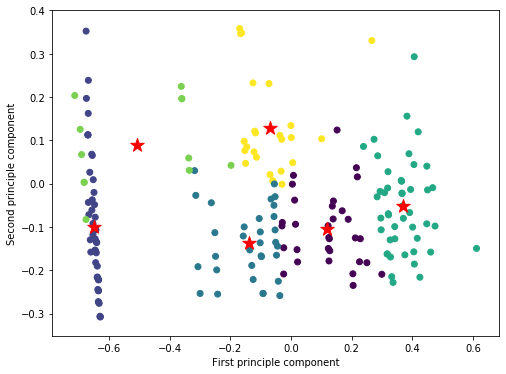

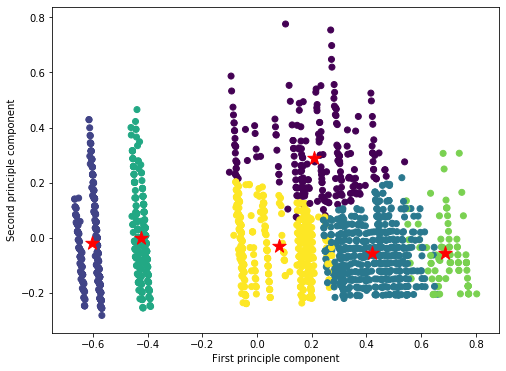

In [121]:
''' To make the 2D PCA plot of the Netherlands with the Dutch cluster centroids'''
PCA_plot_clustering_Netherlands_from_Netherlands_Switzerland_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_Netherlands_Switzerland, cluster_centroids_2D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland)
PCA_plot_clustering_Netherlands_from_Netherlands_Switzerland_dutch_centroids

''' To make the 2D PCA plot of Switzerland with the Swiss cluster centroids'''
PCA_plot_clustering_Switzerland_from_Netherlands_Switzerland_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_Netherlands_Switzerland, cluster_centroids_2D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland)
PCA_plot_clustering_Switzerland_from_Netherlands_Switzerland_swiss_centroids

' To make the 2D PCA plot of Netherlands with the Swiss cluster centroids'

' To make the 2D PCA plot of Switzerland with the Dutch cluster centroids'

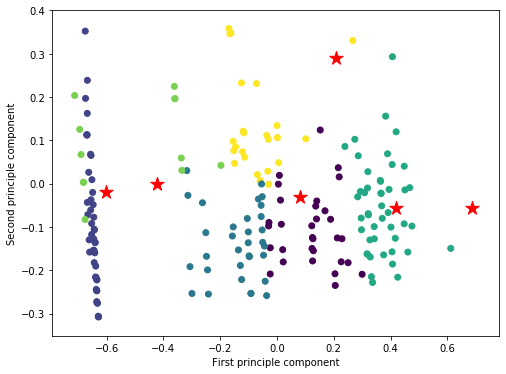

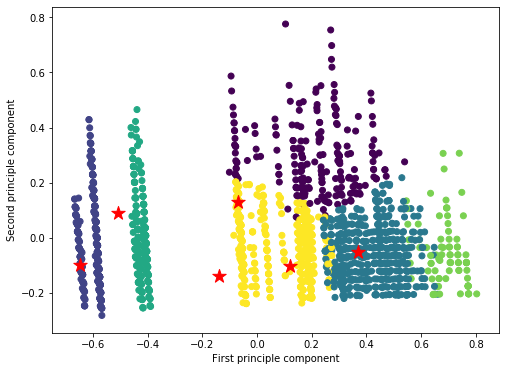

In [122]:
''' To make the 2D PCA plot of Netherlands with the Swiss cluster centroids'''
PCA_plot_clustering_Netherlands_from_Netherlands_Switzerland_swiss_centroids = create_PCA_plot(x_pca_clustering_arr_Netherlands_from_Netherlands_Switzerland, cluster_centroids_2D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland)
PCA_plot_clustering_Netherlands_from_Netherlands_Switzerland_swiss_centroids

''' To make the 2D PCA plot of Switzerland with the Dutch cluster centroids'''
PCA_plot_clustering_Switzerland_from_Netherlands_Switzerland_dutch_centroids = create_PCA_plot(x_pca_clustering_arr_Switzerland_from_Netherlands_Switzerland, cluster_centroids_2D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland)
PCA_plot_clustering_Switzerland_from_Netherlands_Switzerland_dutch_centroids

## K-nearest neighbor method

### Functions

In [123]:
''' To drop the country attribute from the scaled_clustering_df and to convert the result to an array'''
def get_array_routes_other_country(scaled_clustering_df):
    scaled_clustering_arr = scaled_clustering_df.drop('country', axis=1)
    scaled_clustering_arr = scaled_clustering_arr.to_numpy()

    return scaled_clustering_arr

' To drop the country attribute from the scaled_clustering_df and to convert the result to an array'

In [204]:
'''To split the first centroid in the cluster_centroids_5D array off from the other centroids in that array '''
def split_off_the_first_centroid(cluster_centroids_5D):
    first_centroid = cluster_centroids_5D[:1]
    other_centroids = cluster_centroids_5D[1:]

    return first_centroid, other_centroids

'To split the first centroid in the cluster_centroids_5D array off from the other centroids in that array '

In [205]:
''' To get the array that contains the k nearest neighbors of one centroid'''
def get_k_nearest_neighbors_of_centroid(centroid_routes, nearest, k):
    for j in nearest[:, 1:k+1]:
        return centroid_routes[j]

' To get the array that contains the k nearest neighbors of one centroid'

In [206]:
''' To get the list of indices that correspond to the indices of the k nearest neighbors of one centroid in the route_characteristics df'''
def get_indices_k_nearest_neighbors_of_centroid(nearest, k):
    list_indices = []
    for i in nearest[0, 1:k+1]:
        list_indices.append(i-1)

    return list_indices

' To get the list of indices that correspond to the indices of the k nearest neighbors of one centroid in the route_characteristics df'

In [207]:
''' To create the nearest array that contains for each array element an index that corresponds to an array element index of the centroid_routes_arr together 
with the k-nearest neighbor indices of the array element indices of the centroid_routes_arr'''
def to_get_k_nearest_neighbors_of_centroid(centroid_routes_arr):
    D = distance.squareform(distance.pdist(centroid_routes_arr))
    nearest = np.argsort(D, axis=1)

    nearest_neighbors_centroid = get_k_nearest_neighbors_of_centroid(centroid_routes_arr, nearest, 5)
    list_indices_nearest_neighbors = get_indices_k_nearest_neighbors_of_centroid(nearest, 5)

    return nearest_neighbors_centroid, list_indices_nearest_neighbors

' To create the nearest array that contains for each array element an index that corresponds to an array element index of the centroid_routes_arr together \nwith the k-nearest neighbor indices of the array element indices of the centroid_routes_arr'

In [208]:
''' To concatenate the array that contains one centroid with the array that contains the scaled route characteristics of the routes of another country'''
def to_get_array_centroid_routes(first_centroid, scaled_clustering_arr):
    centroid_routes_arr = np.concatenate((first_centroid, scaled_clustering_arr), axis=0)

    return centroid_routes_arr

' To concatenate the array that contains one centroid with the array that contains the scaled route characteristics of the routes of another country'

In [209]:
''' To activate the definition that add the cluster centroid as the first array element of the array that contains the other routes and
to activate the definitions to get the k-nearest neighbors of a centroid as well as the indices of the nearest neighbors in the route_characteristics df'''
def find_k_nearest_neighbors_of_one_centroid(first_centroid, scaled_clustering_arr):
    centroid_routes_arr = to_get_array_centroid_routes(first_centroid, scaled_clustering_arr)
    nearest_neighbors_centroid, list_indices_nearest_neighbors = to_get_k_nearest_neighbors_of_centroid(centroid_routes_arr)

    return nearest_neighbors_centroid, list_indices_nearest_neighbors

' To activate the definition that add the cluster centroid as the first array element of the array that contains the other routes and\nto activate the definitions to get the k-nearest neighbors of a centroid as well as the indices of the nearest neighbors in the route_characteristics df'

In [210]:
''' To find the nearest_neighbors of all centroids and to find the indices of these nearest_neighbors'''
def find_k_nearest_neighbors_of_all_centroids(cluster_centroids_5D, scaled_clustering_df):
    centroids_list = []
    nearest_neighbors_list = []
    indices_nearest_neighbors_list = []
    number_of_cluster_centroids = len(cluster_centroids_5D)
    print("Number of centroids:", number_of_cluster_centroids)
    other_centroids = cluster_centroids_5D.copy()
    scaled_clustering_arr = get_array_routes_other_country(scaled_clustering_df)
    for i in range(0, number_of_cluster_centroids):
        centroid, other_centroids = split_off_the_first_centroid(other_centroids)
        nearest_neighbors_centroid, list_indices_nearest_neighbors = find_k_nearest_neighbors_of_one_centroid(centroid, scaled_clustering_arr)
        nearest_neighbors_list.append(nearest_neighbors_centroid)
        indices_nearest_neighbors_list.append(list_indices_nearest_neighbors)
        centroids_list.append(centroid)    

    return nearest_neighbors_list, indices_nearest_neighbors_list, centroids_list

' To find the nearest_neighbors of all centroids and to find the indices of these nearest_neighbors'

In [276]:
''' To find the nearest neighbors of all centroids and their corresponding route_ids'''
def search_k_nearest_neighbors_of_centroids(cluster_centroids_5D, scaled_clustering_df, route_characteristics):
    nearest_neighbors_list, indices_nearest_neighbors_list, centroids_list = find_k_nearest_neighbors_of_all_centroids(cluster_centroids_5D, scaled_clustering_df)
    k_nearest_neighbors_df = pd.DataFrame(index=range(len(centroids_list)),columns=['centroid', 'nearest_neighbors_centroid', 'route_ids_nearest_neighbors'])
    for nr_centroid, centroid in enumerate(centroids_list):
        #centroid_list = centroid.flatten().tolist()
        #[0] is used to only get one array and not an array of an array
        k_nearest_neighbors_df.loc[nr_centroid,'centroid'] = centroid[0]
        k_nearest_neighbors_df.loc[nr_centroid, 'nearest_neighbors_centroid'] = nearest_neighbors_list[nr_centroid]
        sublist = indices_nearest_neighbors_list[nr_centroid]
        list_route_ids = []
        for listelement in sublist:
            route_id = route_characteristics.loc[listelement,'route_id']
            list_route_ids.append(route_id)
            k_nearest_neighbors_df.loc[nr_centroid, 'route_ids_nearest_neighbors'] = list_route_ids

    return k_nearest_neighbors_df

' To find the nearest neighbors of all centroids and their corresponding route_ids'

### Belgian centroids and Dutch routes

In [277]:
k_nearest_neighbors_df_belgian_centroids_dutch_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands)
k_nearest_neighbors_df_belgian_centroids_dutch_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]"
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]"
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]"
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]"
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]"


### Dutch centroids and Belgian routes

In [217]:
k_nearest_neighbors_df_dutch_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_Belgium_Netherlands, scaled_clustering_df_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium)
k_nearest_neighbors_df_dutch_centroids_belgian_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.6160714285714286, 0.8746975413616875, 0.431...","[[0.375, 0.269562698118741, 0.6914970638533233...","[155.0, 625.0, 624.0, 142.0, 496.0]"
1,"[1.0, 1.0000000000000002, 1.0, 0.1087372448979...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 795.0, 777.0, 790.0]"
2,"[0.20703125, 0.5645590568510037, 0.12549432212...","[[0.1875, 0.23241118809913866, 0.2030146200098...","[529.0, 506.0, 516.0, 776.0, 720.0]"
3,"[0.38344594594594594, 0.7671549907470913, 0.18...","[[0.25, 0.2439087599318336, 0.2626597565283376...","[516.0, 776.0, 325.0, 164.0, 277.0]"
4,"[0.5681818181818182, 0.9370015145873225, 0.774...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 777.0, 795.0, 790.0]"
5,"[0.85625, 0.9721085019101106, 0.87941598904062...","[[0.4375, 0.2534779390388895, 0.78463291439538...","[732.0, 830.0, 726.0, 753.0, 552.0]"


### Belgian centroids and Swiss routes

In [218]:
k_nearest_neighbors_df_belgian_centroids_swiss_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Switzerland, scaled_clustering_df_Switzerland_from_Belgium_Switzerland, route_characteristics_Switzerland)
k_nearest_neighbors_df_belgian_centroids_swiss_routes

Number of centroids: 5


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.3053921568627449, 0.5038056492723987, 0.928...","[[0.625, 0.8432565526082754, 0.446856587099153...","[24006.000011.101:24006, 30197.000011.107:3019..."
1,"[0.1344810379241517, 0.35555161935238094, 0.15...","[[0.125, 0.3581631577354695, 0.022137968834500...","[00402.000029.014:402, 00502.000029.004:502, 0..."
2,"[0.3233640081799596, 0.5139019300070535, 0.978...","[[0.37499999999999994, 0.8901319238800838, 0.4...","[14504.000011.101:30, 14416.000053.101:20, 145..."
3,"[0.22492283950617273, 0.46685336854575993, 0.6...","[[0.3333333333333333, 0.8901319238800838, 0.42...","[14416.000053.101:20, 14504.000011.102:30, 146..."
4,"[0.16500000000000006, 0.3906829843325659, 0.26...","[[0.125, 0.5696566850314, 0.04996237882420905,...","[00215.000043.003:215, 00138.000049.002:138, 0..."


### Swiss centroids and Belgian routes

In [219]:
k_nearest_neighbors_df_swiss_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_Belgium_Switzerland, scaled_clustering_df_Belgium_from_Belgium_Switzerland, route_characteristics_Belgium)
k_nearest_neighbors_df_swiss_centroids_belgian_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.5968076285240465, 0.8482660736733707, 0.434...","[[0.24999999999999997, 0.48256831037569986, 0....","[361.0, 208.0, 142.0, 118.0, 360.0]"
1,"[0.9389191643960054, 0.9999999999999999, 1.0, ...","[[0.3333333333333333, 0.5184154383548972, 0.99...","[795.0, 328.0, 329.0, 790.0, 748.0]"
2,"[0.4688037865748711, 0.8379060437688229, 0.155...","[[0.20833333333333334, 0.4897202557963756, 0.3...","[277.0, 516.0, 776.0, 529.0, 506.0]"
3,"[0.10245098039215687, 0.1356528266679961, 0.00...","[[0.08333333333333334, 0.22216022732153637, 0....","[627.0, 808.0, 513.0, 623.0, 457.0]"
4,"[0.2254842615012112, 0.7027022542763213, 0.053...","[[0.16666666666666666, 0.45323650613827093, 0....","[720.0, 119.0, 195.0, 138.0, 249.0]"
5,"[0.9999999999999998, 0.9704641703566935, 0.601...","[[0.29166666666666663, 0.5184154383548972, 0.8...","[155.0, 625.0, 624.0, 496.0, 328.0]"


### Dutch centroids and Swiss routes

In [220]:
k_nearest_neighbors_df_dutch_centroids_swiss_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_df_Switzerland_from_Netherlands_Switzerland, route_characteristics_Switzerland)
k_nearest_neighbors_df_dutch_centroids_swiss_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.37768817204301075, 0.8331362576335744, 0.27...","[[0.3333333333333333, 0.7067911993975542, 0.16...","[01095.000011.103:1095, 01018.000072.001:1018,..."
1,"[0.708333333333333, 0.9999999999999999, 1.0, 0...","[[0.9166666666666666, 0.748813937777738, 0.796...","[01956.000011.101:36, 30188.000011.103:36, 020..."
2,"[0.4270833333333334, 0.9137740422281911, 0.571...","[[0.3333333333333333, 0.6665431910623193, 0.33...","[30173.000033.102:1, 30055.000033.101:1, 30000..."
3,"[0.20108695652173916, 0.6836234010467968, 0.13...","[[0.29166666666666663, 0.6504909791931395, 0.1...","[04065.000033.101:4065, 28125.06____.005:28125..."
4,"[0.5868055555555555, 0.9717376534476783, 0.864...","[[0.9999999999999999, 0.748813937777738, 0.796...","[00512.000011.101:5, 10513.000011.101:5, 30512..."
5,"[0.44666666666666666, 0.8898452744981559, 0.43...","[[0.49999999999999994, 0.6665431910623193, 0.3...","[30130.000011.107:30130, 30100.000011.101:3010..."


### Swiss centroids and dutch routes

In [221]:
k_nearest_neighbors_df_swiss_centroids_dutch_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_df_Netherlands_from_Netherlands_Switzerland, route_characteristics_Netherlands)
k_nearest_neighbors_df_swiss_centroids_dutch_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.42182890855457233, 0.6111000452856284, 0.14...","[[0.24999999999999997, 0.8047000995318251, 0.1...","[67971.0, 41228.0, 61919.0, 17599.0, 61918.0]"
1,"[0.9389191643960054, 0.7488139377777342, 0.796...","[[0.7083333333333334, 0.9999999999999999, 1.0,...","[52991.0, 17651.0, 77617.0, 73488.0, 77635.0]"
2,"[0.262621359223301, 0.5559180521322173, 0.0572...","[[0.24999999999999997, 0.5506996676352279, 0.1...","[76982.0, 76981.0, 77597.0, 76980.0, 18646.0]"
3,"[0.9999999999999998, 0.7266970968770043, 0.479...","[[0.49999999999999994, 0.8465346492527936, 0.3...","[76990.0, 75062.0, 41239.0, 67394.0, 41238.0]"
4,"[0.10018726591760303, 0.11362401987225335, 0.0...","[[0.041666666666666664, 0.5148378016926168, 0....","[77590.0, 77597.0, 18646.0, 67449.0, 67424.0]"
5,"[0.5659259259259262, 0.6303268820386599, 0.213...","[[0.41666666666666663, 0.8040149192554914, 0.0...","[17828.0, 76990.0, 67394.0, 77596.0, 75062.0]"


## Travel time comparison

### Functions 

In [222]:
''' To add a new avg_travel_time_centroid attribute to the df'''
def add_avg_travel_time_centroid(scaled_clustering_cluster_groups_df, route_characteristics, routes_country, k_nearest_neighbors_df):
    # To add the route_id attribute from the route_characteristics_df to the scaled_clustering_cluster_groups_5D_df
    travel_time_clustering_cluster_groups_df = scaled_clustering_cluster_groups_df.copy()
    travel_time_clustering_cluster_groups_df = travel_time_clustering_cluster_groups_df.reset_index(drop=True)
    travel_time_clustering_cluster_groups_df['route_id'] = route_characteristics['route_id']

    # To merge the country_routes df with the travel_time_clustering_cluster_groups_df on route_id to get the average travel time of a route
    travel_time_clustering_cluster_groups_df = pd.merge(routes_country[['route_id', 'travel_time']], travel_time_clustering_cluster_groups_df, on='route_id')

    # To drop the route_id attribute
    travel_time_clustering_cluster_groups_df = travel_time_clustering_cluster_groups_df.drop('route_id', axis=1)

    # To search for the centroid values of the travel_time for each cluster
    travel_time_centroids_arr = find_cluster_centroids_in_5D(travel_time_clustering_cluster_groups_df)

    # To add the average travel times of the centroids in a list
    list_avg_travel_time_centroids = []
    travel_time_centroids_list = travel_time_centroids_arr.tolist()
    for sublist in travel_time_centroids_list:
        avg_travel_time_centroid = sublist[0]
        list_avg_travel_time_centroids.append(avg_travel_time_centroid)

    # To add the list_avg_travel_time_centroids as a new attribute of the df
    travel_time_df = k_nearest_neighbors_df.copy()
    travel_time_df['avg_travel_time_centroid'] = list_avg_travel_time_centroids

    return travel_time_df

' To add a new avg_travel_time_centroid attribute to the df'

In [223]:
''' To add a new avg_travel_time_nearest_neighbors_centroid attribute to the df'''
def add_avg_travel_time_nearest_neighbors_centroid(travel_time_df_1, routes_country):
    # To copy the travel_time_df_1 and to add a new attribute avg_travel_time_nearest_neighbors_centroid
    travel_time_df = travel_time_df_1.copy()
    travel_time_df['avg_travel_time_nearest_neighbors_centroid'] = ""

    # To loop over the row indices of the travel_time_df
    for row in range(len(travel_time_df)):
        # To select the route_ids_nearest_neighbors attribute value of that row
        list_route_ids_nearest_neighbors = travel_time_df.loc[row, 'route_ids_nearest_neighbors']
        # To create an empty list list_avg_travel_time_nearest_neighbors_centroid
        list_avg_travel_time_nearest_neighbors_centroid = []
        # To loop over all elements in the list_route_ids_nearest_neighbors
        for route_id in list_route_ids_nearest_neighbors:
            # To search for the corresponding average travel time of this route_id
            avg_travel_time = routes_country.loc[routes_country['route_id'] == route_id, 'travel_time'].iloc[0]
            # To add the corresponding average travel time of the route to the list_avg_travel_time_nearest_neighbors_centroids
            list_avg_travel_time_nearest_neighbors_centroid.append(avg_travel_time)
        # To add the list_avg_travel_time_nearest_neighbors_centroid as a new value in the avg_travel_time_nearest_neighbors_centroid column
        travel_time_df.at[row, 'avg_travel_time_nearest_neighbors_centroid'] = list_avg_travel_time_nearest_neighbors_centroid

    return travel_time_df

' To add a new avg_travel_time_nearest_neighbors_centroid attribute to the df'

In [224]:
def get_the_average_travel_time(scaled_clustering_cluster_groups_df, route_characteristics, k_nearest_neighbors_df, routes_centroid_country, routes_non_centroid_country):
    travel_time_df_1 = add_avg_travel_time_centroid(scaled_clustering_cluster_groups_df, route_characteristics, routes_centroid_country, k_nearest_neighbors_df)
    travel_time_df = add_avg_travel_time_nearest_neighbors_centroid(travel_time_df_1, routes_non_centroid_country)

    return travel_time_df

In [225]:
def calculate_variance_avg_tt_nn_centroid(travel_time_df):
    #calculates variance of the avg_travel_time_nearest_neighbors_centroid
    travel_time_df['variance_avg_tt_nn_centroid'] = travel_time_df['avg_travel_time_nearest_neighbors_centroid'].apply(lambda x: np.var(x))
    return travel_time_df

In [226]:
def calculate_avg_difference_avgtt_centroid_avgtt_nn(travel_time_df):
    travel_time_df['difference_avgtt_centroid_avgtt_nn'] = np.empty((len(travel_time_df), 0)).tolist()
    for index_row, row in travel_time_df.iterrows():
        #creates a list of difference between the avg_travel_time_centroid and avg_travel_time_nn_centroid
        for avg_tt_nn_centroid in row['avg_travel_time_nearest_neighbors_centroid']:
            travel_time_df.loc[index_row, 'difference_avgtt_centroid_avgtt_nn'].append(row['avg_travel_time_centroid'] - avg_tt_nn_centroid)
    return travel_time_df

### Belgian centroids and dutch routes

In [227]:
travel_time_df_belgian_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_dutch_routes, belgian_routes_Belgium, dutch_routes_Netherlands)
travel_time_df_belgian_centroids_dutch_routes = calculate_variance_avg_tt_nn_centroid(travel_time_df_belgian_centroids_dutch_routes)
travel_time_df_belgian_centroids_dutch_routes = calculate_avg_difference_avgtt_centroid_avgtt_nn(travel_time_df_belgian_centroids_dutch_routes)
travel_time_df_belgian_centroids_dutch_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid,variance_avg_tt_nn_centroid,difference_avgtt_centroid_avgtt_nn
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]",91.184507,"[34.491134372997216, 54.17122807017546, 95.5, ...",1109.028531,"[56.693372984143274, 37.01327928696503, -4.315..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]",164.239347,"[124.7624, 36.00228519195612, 104.224384432088...",1285.937218,"[39.47694679293615, 128.23706160098004, 60.014..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]",36.925312,"[54.17122807017546, 33.72085201793721, 34.4911...",671.342969,"[-17.24591622899652, 3.204459823241727, 2.4341..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]",71.034073,"[134.04902203515724, 10.0, 18.285714285714285,...",2009.278830,"[-63.01494874566254, 61.0340732894947, 52.7483..."
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]",76.550359,"[36.00228519195612, 50.0, 15.000000000000002, ...",1729.863527,"[40.54807428650062, 26.55035947845674, 61.5503..."
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]",137.982999,"[134.04902203515724, 104.22438443208895, 36.00...",1429.397006,"[3.9339764696047155, 33.758614072673, 101.9807..."


### Dutch centroids and belgian routes

In [228]:
travel_time_df_dutch_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_belgian_routes, dutch_routes_Netherlands, belgian_routes_Belgium)
travel_time_df_dutch_centroids_belgian_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.6160714285714286, 0.8746975413616875, 0.431...","[[0.375, 0.269562698118741, 0.6914970638533233...","[155.0, 625.0, 624.0, 142.0, 496.0]",79.593091,"[35.74725274725274, 38.0, 48.0, 58.0, 68.0]"
1,"[1.0, 1.0000000000000002, 1.0, 0.1087372448979...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 795.0, 777.0, 790.0]",98.998928,"[58.8888888888889, 48.0, 83.75, 51.71428571428..."
2,"[0.20703125, 0.5645590568510037, 0.12549432212...","[[0.1875, 0.23241118809913866, 0.2030146200098...","[529.0, 506.0, 516.0, 776.0, 720.0]",42.682699,"[34.0, 51.0, 28.0, 37.588235294117645, 30.0]"
3,"[0.38344594594594594, 0.7671549907470913, 0.18...","[[0.25, 0.2439087599318336, 0.2626597565283376...","[516.0, 776.0, 325.0, 164.0, 277.0]",46.395882,"[28.0, 37.588235294117645, 18.0, 12.4848484848..."
4,"[0.5681818181818182, 0.9370015145873225, 0.774...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 777.0, 795.0, 790.0]",87.861775,"[58.8888888888889, 48.0, 51.71428571428571, 83..."
5,"[0.85625, 0.9721085019101106, 0.87941598904062...","[[0.4375, 0.2534779390388895, 0.78463291439538...","[732.0, 830.0, 726.0, 753.0, 552.0]",472.225665,"[147.93023255813952, 200.062013229489, 172.550..."


### Belgian centroids and Swiss routes

In [229]:
travel_time_df_belgian_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_swiss_routes, belgian_routes_Belgium, swiss_routes_Switzerland)
travel_time_df_belgian_centroids_swiss_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.3053921568627449, 0.5038056492723987, 0.928...","[[0.625, 0.8432565526082754, 0.446856587099153...","[24006.000011.101:24006, 30197.000011.107:3019...",156.704497,"[104.0, 121.0, 93.0, 93.0, 88.0]"
1,"[0.1344810379241517, 0.35555161935238094, 0.15...","[[0.125, 0.3581631577354695, 0.022137968834500...","[00402.000029.014:402, 00502.000029.004:502, 0...",36.925312,"[14.0, 13.0, 17.0, 21.0, 34.0]"
2,"[0.3233640081799596, 0.5139019300070535, 0.978...","[[0.37499999999999994, 0.8901319238800838, 0.4...","[14504.000011.101:30, 14416.000053.101:20, 145...",86.657776,"[55.0, 53.0, 48.0, 42.0, 103.0]"
3,"[0.22492283950617273, 0.46685336854575993, 0.6...","[[0.3333333333333333, 0.8901319238800838, 0.42...","[14416.000053.101:20, 14504.000011.102:30, 146...",75.551789,"[53.0, 48.0, 42.0, 55.0, 41.0]"
4,"[0.16500000000000006, 0.3906829843325659, 0.26...","[[0.125, 0.5696566850314, 0.04996237882420905,...","[00215.000043.003:215, 00138.000049.002:138, 0...",91.184507,"[79.0, 36.0, 33.0, 43.0, 45.0]"


### Swiss centroids and Belgian routes

In [230]:
travel_time_df_swiss_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_belgian_routes, swiss_routes_Switzerland, belgian_routes_Belgium)
travel_time_df_swiss_centroids_belgian_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.5968076285240465, 0.8482660736733707, 0.434...","[[0.24999999999999997, 0.48256831037569986, 0....","[361.0, 208.0, 142.0, 118.0, 360.0]",89.109453,"[40.0, 75.5, 58.0, 69.0, 48.60714285714286]"
1,"[0.9389191643960054, 0.9999999999999999, 1.0, ...","[[0.3333333333333333, 0.5184154383548972, 0.99...","[795.0, 328.0, 329.0, 790.0, 748.0]",84.659401,"[83.75, 58.8888888888889, 48.0, 44.0, 66.11764..."
2,"[0.4688037865748711, 0.8379060437688229, 0.155...","[[0.20833333333333334, 0.4897202557963756, 0.3...","[277.0, 516.0, 776.0, 529.0, 506.0]",57.640275,"[55.0, 28.0, 37.588235294117645, 34.0, 51.0]"
3,"[0.10245098039215687, 0.1356528266679961, 0.00...","[[0.08333333333333334, 0.22216022732153637, 0....","[627.0, 808.0, 513.0, 623.0, 457.0]",50.870588,"[37.0, 29.3, 31.66403162055336, 27.4, 35.0]"
4,"[0.2254842615012112, 0.7027022542763213, 0.053...","[[0.16666666666666666, 0.45323650613827093, 0....","[720.0, 119.0, 195.0, 138.0, 249.0]",40.087167,"[30.0, 27.0, 35.0, 49.0, 41.72395833333334]"
5,"[0.9999999999999998, 0.9704641703566935, 0.601...","[[0.29166666666666663, 0.5184154383548972, 0.8...","[155.0, 625.0, 624.0, 496.0, 328.0]",75.692029,"[35.74725274725274, 38.0, 48.0, 68.0, 58.88888..."


### Dutch centroids and Swiss routes

In [231]:
travel_time_df_dutch_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_swiss_routes, dutch_routes_Netherlands, swiss_routes_Switzerland)
travel_time_df_dutch_centroids_swiss_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.37768817204301075, 0.8331362576335744, 0.27...","[[0.3333333333333333, 0.7067911993975542, 0.16...","[01095.000011.103:1095, 01018.000072.001:1018,...",43.386951,"[79.0, 67.0, 40.0, 19.0, 17.0]"
1,"[0.708333333333333, 0.9999999999999999, 1.0, 0...","[[0.9166666666666666, 0.748813937777738, 0.796...","[01956.000011.101:36, 30188.000011.103:36, 020...",98.998928,"[75.0, 88.0, 87.00000000000001, 73.0, 72.0]"
2,"[0.4270833333333334, 0.9137740422281911, 0.571...","[[0.3333333333333333, 0.6665431910623193, 0.33...","[30173.000033.102:1, 30055.000033.101:1, 30000...",60.674201,"[17.0, 19.0, 50.0, 42.0, 17.0]"
3,"[0.20108695652173916, 0.6836234010467968, 0.13...","[[0.29166666666666663, 0.6504909791931395, 0.1...","[04065.000033.101:4065, 28125.06____.005:28125...",43.415405,"[72.0, 31.0, 42.0, 19.0, 21.0]"
4,"[0.5868055555555555, 0.9717376534476783, 0.864...","[[0.9999999999999999, 0.748813937777738, 0.796...","[00512.000011.101:5, 10513.000011.101:5, 30512...",435.867433,"[238.0, 237.0, 245.0, 229.0, 245.0]"
5,"[0.44666666666666666, 0.8898452744981559, 0.43...","[[0.49999999999999994, 0.6665431910623193, 0.3...","[30130.000011.107:30130, 30100.000011.101:3010...",108.574222,"[136.0, 132.0, 55.0, 104.0, 53.0]"


### Swiss centroids and dutch routes

In [232]:
travel_time_df_swiss_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_dutch_routes, swiss_routes_Switzerland, dutch_routes_Netherlands)
travel_time_df_swiss_centroids_dutch_routes

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.42182890855457233, 0.6111000452856284, 0.14...","[[0.24999999999999997, 0.8047000995318251, 0.1...","[67971.0, 41228.0, 61919.0, 17599.0, 61918.0]",94.929204,"[150.00814971325082, 74.24862637362638, 90.999..."
1,"[0.9389191643960054, 0.7488139377777342, 0.796...","[[0.7083333333333334, 0.9999999999999999, 1.0,...","[52991.0, 17651.0, 77617.0, 73488.0, 77635.0]",84.659401,"[54.05093833780161, 51.84615384615386, 44.4444..."
2,"[0.262621359223301, 0.5559180521322173, 0.0572...","[[0.24999999999999997, 0.5506996676352279, 0.1...","[76982.0, 76981.0, 77597.0, 76980.0, 18646.0]",36.535922,"[28.20920138888889, 49.989147909967855, 33.720..."
3,"[0.9999999999999998, 0.7266970968770043, 0.479...","[[0.49999999999999994, 0.8465346492527936, 0.3...","[76990.0, 75062.0, 41239.0, 67394.0, 41238.0]",75.692029,"[125.52380952380956, 156.00420168067228, 54.84..."
4,"[0.10018726591760303, 0.11362401987225335, 0.0...","[[0.041666666666666664, 0.5148378016926168, 0....","[77590.0, 77597.0, 18646.0, 67449.0, 67424.0]",48.842697,"[18.875, 33.72085201793721, 95.5, 54.171228070..."
5,"[0.5659259259259262, 0.6303268820386599, 0.213...","[[0.41666666666666663, 0.8040149192554914, 0.0...","[17828.0, 76990.0, 67394.0, 77596.0, 75062.0]",61.473333,"[42.52192895415757, 125.52380952380956, 88.000..."


## Search the k-nearest neighbors of the country of the centroid as well

In [233]:
k_nearest_neighbors_df_belgian_centroids_belgian_routes = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium)
k_nearest_neighbors_df_belgian_centroids_belgian_routes

Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.15001558792723865, 0.2133989939790...","[395.0, 444.0, 159.0, 725.0, 778.0]"
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.375, 0.269562698118741, 0.6914970638533233...","[829.0, 224.0, 202.0, 828.0, 227.0]"
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.125, 0.13728860277029467, 0.13563070276014...","[715.0, 294.0, 132.0, 127.0, 437.0]"
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.4375, 0.269562698118741, 0.784632914395388...","[789.0, 362.0, 696.0, 189.0, 288.0]"
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.19883920262389507, 0.537105596626653...","[504.0, 491.0, 805.0, 500.0, 499.0]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.4375, 0.2555753818330926, 0.78463291439538...","[779.0, 825.0, 368.0, 700.0, 342.0]"


In [242]:
# Belgische centroids met Nederlandse routes
#search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands)
get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_dutch_routes, belgian_routes_Belgium, dutch_routes_Netherlands)

# Belgische centroids met Belgische routes
#search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium)
get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_belgian_routes, belgian_routes_Belgium, belgian_routes_Belgium)

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]",91.184507,"[34.491134372997216, 54.17122807017546, 95.5, ..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]",164.239347,"[124.7624, 36.00228519195612, 104.224384432088..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]",36.925312,"[54.17122807017546, 33.72085201793721, 34.4911..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]",71.034073,"[134.04902203515724, 10.0, 18.285714285714285,..."
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]",76.550359,"[36.00228519195612, 50.0, 15.000000000000002, ..."
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]",137.982999,"[134.04902203515724, 104.22438443208895, 36.00..."


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.15001558792723865, 0.2133989939790...","[395.0, 444.0, 159.0, 725.0, 778.0]",91.184507,"[82.0, 115.55094991364422, 97.04166666666666, ..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.375, 0.269562698118741, 0.6914970638533233...","[829.0, 224.0, 202.0, 828.0, 227.0]",164.239347,"[186.5, 168.81856187290967, 174.59047619047618..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.125, 0.13728860277029467, 0.13563070276014...","[715.0, 294.0, 132.0, 127.0, 437.0]",36.925312,"[34.0, 60.44, 54.00000000000001, 26.5121951219..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.4375, 0.269562698118741, 0.784632914395388...","[789.0, 362.0, 696.0, 189.0, 288.0]",71.034073,"[65.0, 66.5, 59.0, 60.81300813008131, 60.22105..."
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.19883920262389507, 0.537105596626653...","[504.0, 491.0, 805.0, 500.0, 499.0]",76.550359,"[77.0, 95.5, 103.5, 71.5, 70.0]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.4375, 0.2555753818330926, 0.78463291439538...","[779.0, 825.0, 368.0, 700.0, 342.0]",137.982999,"[166.7647058823529, 143.0, 153.5, 141.16666666..."


# Werkt nog niet met definitie ! De versie zonder definitie gebruiken

In [257]:
''' To get a dataframe with the nearest neighbors and the avg_travel_time of these nearest neighbors'''
def get_nearest_neighbors_and_average_travel_time(cluster_centroids_5D_df, scaled_clustering_df_non_centroid_country, route_characteristics_not_country_centroid, scaled_clustering_cluster_groups_5D_df, route_characteristics_country_centroid, routes_country_centroid, routes_not_country_centroid):
    k_nearest_neighbors_df = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_df, scaled_clustering_df_non_centroid_country, route_characteristics_not_country_centroid)
    travel_time_df = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_df, route_characteristics_country_centroid, k_nearest_neighbors_df, routes_country_centroid, routes_not_country_centroid)

    return travel_time_df

' To get a dataframe with the nearest neighbors and the avg_travel_time of these nearest neighbors'

In [273]:
def get_nearest_neighbors_two_countries(cluster_centroids_5D_df, scaled_clustering_df_not_country_centroid, route_characteristics_not_country_centroid, scaled_clustering_cluster_groups_5D_df, route_characteristics_country_centroid, routes_country_centroid, routes_not_country_centroid, scaled_clustering_df_country_centroid, country_suffix, other_suffix):
    travel_time_df_not_country_centroid_neighbors = get_nearest_neighbors_and_average_travel_time(cluster_centroids_5D_df, scaled_clustering_df_not_country_centroid, route_characteristics_not_country_centroid, scaled_clustering_cluster_groups_5D_df, route_characteristics_country_centroid, routes_country_centroid, routes_not_country_centroid)
    travel_time_df_country_centroid_neighbors = get_nearest_neighbors_and_average_travel_time(cluster_centroids_5D_df, scaled_clustering_df_country_centroid, route_characteristics_country_centroid, scaled_clustering_cluster_groups_5D_df, route_characteristics_country_centroid, routes_country_centroid, routes_country_centroid)

    #Merging
    travel_time_df_merged =  pd.merge(travel_time_df_not_country_centroid_neighbors, travel_time_df_country_centroid_neighbors, 
                    left_index = True, right_index = True, 
                    suffixes=(other_suffix, country_suffix), on='centroid',
                    how='inner')

    
    return travel_time_df_country_centroid_neighbors, travel_time_df_not_country_centroid_neighbors, travel_time_df_merged

In [274]:
travel_time_df_belgian_centroids_belgian_routes, travel_time_df_belgian_centroids_dutch_routes, merged_travel_time_df_belgian_centroids_dutch_routes = get_nearest_neighbors_two_countries(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands, scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, belgian_routes_Belgium, dutch_routes_Netherlands, scaled_clustering_df_Netherlands_from_Belgium_Netherlands, '_belgian_neighbors','_dutch_neighbors')
travel_time_df_belgian_centroids_belgian_routes
travel_time_df_belgian_centroids_dutch_routes
merged_travel_time_df_belgian_centroids_dutch_routes

Number of centroids: 6
Number of centroids: 6


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[185.0, 256.0, 141.0, 290.0, 275.0]",91.184507,"[157.38315217391306, 77.81223628691983, 56.773..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[290.0, 190.0, 315.0, 231.0, 254.0]",164.239347,"[87.21739130434781, 50.0, 68.71517027863777, 1..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[256.0, 293.0, 185.0, 141.0, 253.0]",36.925312,"[77.81223628691983, 90.0, 157.38315217391306, ..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[254.0, 284.0, 285.0, 190.0, 208.0]",71.034073,"[33.8, 35.0, 78.0, 50.0, 75.5]"
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[190.0, 186.0, 309.0, 254.0, 185.0]",76.550359,"[50.0, 13.0, 68.75, 33.8, 157.38315217391306]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[254.0, 315.0, 190.0, 231.0, 224.0]",137.982999,"[33.8, 68.71517027863777, 50.0, 117.3501055594..."


,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]",91.184507,"[34.491134372997216, 54.17122807017546, 95.5, ..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]",164.239347,"[124.7624, 36.00228519195612, 104.224384432088..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]",36.925312,"[54.17122807017546, 33.72085201793721, 34.4911..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]",71.034073,"[134.04902203515724, 10.0, 18.285714285714285,..."
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]",76.550359,"[36.00228519195612, 50.0, 15.000000000000002, ..."
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]",137.982999,"[134.04902203515724, 104.22438443208895, 36.00..."


,centroid,nearest_neighbors_centroid_dutch_neighbors,route_ids_nearest_neighbors_dutch_neighbors,avg_travel_time_centroid_dutch_neighbors,avg_travel_time_nearest_neighbors_centroid_dutch_neighbors,nearest_neighbors_centroid_belgian_neighbors,route_ids_nearest_neighbors_belgian_neighbors,avg_travel_time_centroid_belgian_neighbors,avg_travel_time_nearest_neighbors_centroid_belgian_neighbors
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]",91.184507,"[34.491134372997216, 54.17122807017546, 95.5, ...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[185.0, 256.0, 141.0, 290.0, 275.0]",91.184507,"[157.38315217391306, 77.81223628691983, 56.773..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]",164.239347,"[124.7624, 36.00228519195612, 104.224384432088...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[290.0, 190.0, 315.0, 231.0, 254.0]",164.239347,"[87.21739130434781, 50.0, 68.71517027863777, 1..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]",36.925312,"[54.17122807017546, 33.72085201793721, 34.4911...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[256.0, 293.0, 185.0, 141.0, 253.0]",36.925312,"[77.81223628691983, 90.0, 157.38315217391306, ..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]",71.034073,"[134.04902203515724, 10.0, 18.285714285714285,...","[[0.375, 0.6187578677198726, 0.294845584912792...","[254.0, 284.0, 285.0, 190.0, 208.0]",71.034073,"[33.8, 35.0, 78.0, 50.0, 75.5]"
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]",76.550359,"[36.00228519195612, 50.0, 15.000000000000002, ...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[190.0, 186.0, 309.0, 254.0, 185.0]",76.550359,"[50.0, 13.0, 68.75, 33.8, 157.38315217391306]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]",137.982999,"[134.04902203515724, 104.22438443208895, 36.00...","[[0.375, 0.6187578677198726, 0.294845584912792...","[254.0, 315.0, 190.0, 231.0, 224.0]",137.982999,"[33.8, 68.71517027863777, 50.0, 117.3501055594..."


# Werkt hieronder maar geen definitie gebruikt

## Belgian centroids + Dutch and Belgian nearest neighbors

In [236]:
# Belgian centroids + Dutch nearest neighbors
travel_time_df_belgian_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_dutch_routes, belgian_routes_Belgium, dutch_routes_Netherlands)
#travel_time_df_belgian_centroids_dutch_routes

In [237]:
#focus op Belgische routes vanaf hier
k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Netherlands, scaled_clustering_df_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium)
#k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands

Number of centroids: 6


In [238]:
travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Netherlands, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands, belgian_routes_Belgium, belgian_routes_Belgium)
#travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands

In [239]:
travel_time_df_belgian_centroids_from_Belgium_Netherlands =     pd.merge(travel_time_df_belgian_centroids_dutch_routes, travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Netherlands, 
                    left_index = True, right_index = True, 
                    suffixes=('_dutch_neighbors', '_belgian_neighbors'), on='centroid',
                    how='inner')
travel_time_df_belgian_centroids_from_Belgium_Netherlands

,centroid,nearest_neighbors_centroid_dutch_neighbors,route_ids_nearest_neighbors_dutch_neighbors,avg_travel_time_centroid_dutch_neighbors,avg_travel_time_nearest_neighbors_centroid_dutch_neighbors,nearest_neighbors_centroid_belgian_neighbors,route_ids_nearest_neighbors_belgian_neighbors,avg_travel_time_centroid_belgian_neighbors,avg_travel_time_nearest_neighbors_centroid_belgian_neighbors
0,"[0.185, 0.1553679034605081, 0.1978064524091418...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[45223.0, 67449.0, 18646.0, 77594.0, 76981.0]",91.184507,"[34.491134372997216, 54.17122807017546, 95.5, ...","[[0.1875, 0.15001558792723865, 0.2133989939790...","[395.0, 444.0, 159.0, 725.0, 778.0]",91.184507,"[82.0, 115.55094991364422, 97.04166666666666, ..."
1,"[0.3577586206896552, 0.2376982176923387, 0.666...","[[0.0625, 0.5380612918693545, 0.17744293408079...","[77594.0, 45231.0, 77619.0, 61914.0, 67425.0]",164.239347,"[124.7624, 36.00228519195612, 104.224384432088...","[[0.375, 0.269562698118741, 0.6914970638533233...","[829.0, 224.0, 202.0, 828.0, 227.0]",164.239347,"[186.5, 168.81856187290967, 174.59047619047618..."
2,"[0.13922155688622753, 0.12395991838199134, 0.1...","[[0.1875, 0.45546974218927627, 0.0880029514135...","[67449.0, 77597.0, 45223.0, 18646.0, 67424.0]",36.925312,"[54.17122807017546, 33.72085201793721, 34.4911...","[[0.125, 0.13728860277029467, 0.13563070276014...","[715.0, 294.0, 132.0, 127.0, 437.0]",36.925312,"[34.0, 60.44, 54.00000000000001, 26.5121951219..."
3,"[0.4357142857142857, 0.2660111200497624, 0.781...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77367.0, 77574.0, 45231.0, 52989.0]",71.034073,"[134.04902203515724, 10.0, 18.285714285714285,...","[[0.4375, 0.269562698118741, 0.784632914395388...","[789.0, 362.0, 696.0, 189.0, 288.0]",71.034073,"[65.0, 66.5, 59.0, 60.81300813008131, 60.22105..."
4,"[0.2722457627118644, 0.22689751627464227, 0.53...","[[0.25, 0.522063526790569, 0.2163059698570339,...","[45231.0, 45224.0, 77613.0, 67425.0, 45223.0]",76.550359,"[36.00228519195612, 50.0, 15.000000000000002, ...","[[0.25, 0.19883920262389507, 0.537105596626653...","[504.0, 491.0, 805.0, 500.0, 499.0]",76.550359,"[77.0, 95.5, 103.5, 71.5, 70.0]"
5,"[0.42247596153846156, 0.2655725420298948, 0.77...","[[0.375, 0.6187578677198726, 0.294845584912792...","[67425.0, 77619.0, 45231.0, 61914.0, 53004.0]",137.982999,"[134.04902203515724, 104.22438443208895, 36.00...","[[0.4375, 0.2555753818330926, 0.78463291439538...","[779.0, 825.0, 368.0, 700.0, 342.0]",137.982999,"[166.7647058823529, 143.0, 153.5, 141.16666666..."


Dutch centroids + Belgian and Dutch nearest neighbors

In [158]:
#Dutch centroids with Belgian nearest neighbors
travel_time_df_dutch_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_belgian_routes, dutch_routes_Netherlands, belgian_routes_Belgium)
#travel_time_df_dutch_centroids_belgian_routes

In [159]:
#To search the Dutch nearest neighbors with the Dutch centroid
k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_Belgium_Netherlands, scaled_clustering_df_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands)
#k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands

Number of centroids: 6


In [160]:
# To search the avg_travel_time of the Dutch nearest neighbors
travel_time_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Belgium_Netherlands, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands, dutch_routes_Netherlands, dutch_routes_Netherlands)
#travel_time_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands 

In [161]:
# To get the dataframe with the Belgian and the Dutch nearest neighbors searched with the Dutch centroids
travel_time_df_dutch_centroids_from_Belgium_Netherlands =     pd.merge(travel_time_df_dutch_centroids_belgian_routes, travel_time_df_dutch_centroids_dutch_routes_from_Belgium_Netherlands[['centroid', 'avg_travel_time_nearest_neighbors_centroid']], 
                    left_index = True, right_index = True, 
                    suffixes=('_Belgian_neighbors', '_Dutch_neighbors'), on='centroid',
                    how='inner')
travel_time_df_dutch_centroids_from_Belgium_Netherlands

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid_Belgian_neighbors,avg_travel_time_nearest_neighbors_centroid_Dutch_neighbors
0,"[[0.6160714285714286, 0.8746975413616875, 0.43...","[[0.375, 0.269562698118741, 0.6914970638533233...","[155.0, 625.0, 624.0, 142.0, 496.0]",79.593091,"[35.74725274725274, 38.0, 48.0, 58.0, 68.0]","[59.00000000000002, 70.21553610503284, 52.0304..."
1,"[[1.0, 1.0000000000000002, 1.0, 0.108737244897...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 795.0, 777.0, 790.0]",98.998928,"[58.8888888888889, 48.0, 83.75, 51.71428571428...","[90.21485411140587, 103.75172413793103, 136.0,..."
2,"[[0.20703125, 0.5645590568510037, 0.1254943221...","[[0.1875, 0.23241118809913866, 0.2030146200098...","[529.0, 506.0, 516.0, 776.0, 720.0]",42.682699,"[34.0, 51.0, 28.0, 37.588235294117645, 30.0]","[33.0, 27.99987207368556, 37.48493455174117, 4..."
3,"[[0.38344594594594594, 0.7671549907470913, 0.1...","[[0.25, 0.2439087599318336, 0.2626597565283376...","[516.0, 776.0, 325.0, 164.0, 277.0]",46.395882,"[28.0, 37.588235294117645, 18.0, 12.4848484848...","[60.80036630036631, 64.99230769230769, 29.5101..."
4,"[[0.5681818181818182, 0.9370015145873225, 0.77...","[[0.4375, 0.269562698118741, 0.784632914395388...","[328.0, 329.0, 777.0, 795.0, 790.0]",87.861775,"[58.8888888888889, 48.0, 51.71428571428571, 83...","[72.0, 126.03549420754247, 47.084611578426504,..."
5,"[[0.85625, 0.9721085019101106, 0.8794159890406...","[[0.4375, 0.2534779390388895, 0.78463291439538...","[732.0, 830.0, 726.0, 753.0, 552.0]",472.225665,"[147.93023255813952, 200.062013229489, 172.550...","[431.77777777777777, 402.0, 477.0, 486.0, 493.0]"


Belgian centroids and Swiss and Belgian nearest neighbors

In [162]:
#Belgian centroids with Swiss nearest neighbors
travel_time_df_belgian_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_swiss_routes, belgian_routes_Belgium, swiss_routes_Switzerland)
#travel_time_df_belgian_centroids_swiss_routes

In [163]:
#To search the Belgian nearest neighbors with the Belgian centroids
k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Belgium_from_Belgium_Switzerland, scaled_clustering_df_Belgium_from_Belgium_Switzerland, route_characteristics_Belgium)
#k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland

Number of centroids: 5


In [164]:
# To search the avg_travel_time of the Belgian nearest neighbors
travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Belgium_from_Belgium_Switzerland, route_characteristics_Belgium, k_nearest_neighbors_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland, belgian_routes_Belgium, belgian_routes_Belgium)
#travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland

In [165]:
# To get the dataframe with the Swiss and the Belgian nearest neighbors searched with the Belgian centroids
travel_time_df_belgian_centroids_from_Belgium_Switzerland =     pd.merge(travel_time_df_belgian_centroids_swiss_routes, travel_time_df_belgian_centroids_belgian_routes_from_Belgium_Switzerland[['centroid', 'avg_travel_time_nearest_neighbors_centroid']], 
                    left_index = True, right_index = True, 
                    suffixes=('_Swiss_neighbors', '_Belgian_neighbors'), on='centroid',
                    how='inner')
travel_time_df_belgian_centroids_from_Belgium_Switzerland

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid_Swiss_neighbors,avg_travel_time_nearest_neighbors_centroid_Belgian_neighbors
0,"[[0.3053921568627449, 0.5038056492723987, 0.92...","[[0.625, 0.8432565526082754, 0.446856587099153...","[24006.000011.101:24006, 30197.000011.107:3019...",156.704497,"[104.0, 121.0, 93.0, 93.0, 88.0]","[210.007722007722, 161.79310344827587, 158.571..."
1,"[[0.1344810379241517, 0.35555161935238094, 0.1...","[[0.125, 0.3581631577354695, 0.022137968834500...","[00402.000029.014:402, 00502.000029.004:502, 0...",36.925312,"[14.0, 13.0, 17.0, 21.0, 34.0]","[34.0, 54.00000000000001, 60.44, 37.4243222175..."
2,"[[0.3233640081799596, 0.5139019300070535, 0.97...","[[0.37499999999999994, 0.8901319238800838, 0.4...","[14504.000011.101:30, 14416.000053.101:20, 145...",86.657776,"[55.0, 53.0, 48.0, 42.0, 103.0]","[88.26190476190477, 97.45763612217795, 99.2619..."
3,"[[0.22492283950617273, 0.46685336854575993, 0....","[[0.3333333333333333, 0.8901319238800838, 0.42...","[14416.000053.101:20, 14504.000011.102:30, 146...",75.551789,"[53.0, 48.0, 42.0, 55.0, 41.0]","[77.0, 70.0, 95.5, 103.5, 71.5]"
4,"[[0.16500000000000006, 0.3906829843325659, 0.2...","[[0.125, 0.5696566850314, 0.04996237882420905,...","[00215.000043.003:215, 00138.000049.002:138, 0...",91.184507,"[79.0, 36.0, 33.0, 43.0, 45.0]","[82.0, 115.55094991364422, 97.04166666666666, ..."


Swiss centroids and Belgian and Swiss nearest neighbors

In [166]:
#Swiss centroids with Belgian nearest neighbors
travel_time_df_swiss_centroids_belgian_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_belgian_routes, swiss_routes_Switzerland, belgian_routes_Belgium)
#travel_time_df_swiss_centroids_belgian_routes

In [167]:
#To search the Swiss nearest neighbors with the Swiss centroids
k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_Belgium_Switzerland, scaled_clustering_df_Switzerland_from_Belgium_Switzerland, route_characteristics_Switzerland)
#k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland

Number of centroids: 6


In [168]:
# To search the avg_travel_time of the Swiss nearest neighbors
travel_time_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Belgium_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland, swiss_routes_Switzerland, swiss_routes_Switzerland)
#travel_time_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland

In [169]:
# To get the dataframe with the Belgian and the Swiss nearest neighbors searched with the Swiss centroids
travel_time_df_swiss_centroids_from_Belgium_Switzerland =     pd.merge(travel_time_df_swiss_centroids_belgian_routes, travel_time_df_swiss_centroids_swiss_routes_from_Belgium_Switzerland[['centroid', 'avg_travel_time_nearest_neighbors_centroid']], 
                    left_index = True, right_index = True, 
                    suffixes=('_Belgian_neighbors', '_Swiss_neighbors'), on='centroid',
                    how='inner')
travel_time_df_swiss_centroids_from_Belgium_Switzerland

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid_Belgian_neighbors,avg_travel_time_nearest_neighbors_centroid_Swiss_neighbors
0,"[[0.5968076285240465, 0.8482660736733707, 0.43...","[[0.24999999999999997, 0.48256831037569986, 0....","[361.0, 208.0, 142.0, 118.0, 360.0]",89.109453,"[40.0, 75.5, 58.0, 69.0, 48.60714285714286]","[115.0, 125.0, 75.0, 83.0, 90.0]"
1,"[[0.9389191643960054, 0.9999999999999999, 1.0,...","[[0.3333333333333333, 0.5184154383548972, 0.99...","[795.0, 328.0, 329.0, 790.0, 748.0]",84.659401,"[83.75, 58.8888888888889, 48.0, 44.0, 66.11764...","[109.0, 87.00000000000001, 78.0, 75.0, 86.0]"
2,"[[0.4688037865748711, 0.8379060437688229, 0.15...","[[0.20833333333333334, 0.4897202557963756, 0.3...","[277.0, 516.0, 776.0, 529.0, 506.0]",57.640275,"[55.0, 28.0, 37.588235294117645, 34.0, 51.0]","[65.0, 61.0, 58.0, 53.0, 60.0]"
3,"[[0.10245098039215687, 0.1356528266679961, 0.0...","[[0.08333333333333334, 0.22216022732153637, 0....","[627.0, 808.0, 513.0, 623.0, 457.0]",50.870588,"[37.0, 29.3, 31.66403162055336, 27.4, 35.0]","[12.0, 16.0, 39.0, 51.0, 12.0]"
4,"[[0.2254842615012112, 0.7027022542763213, 0.05...","[[0.16666666666666666, 0.45323650613827093, 0....","[720.0, 119.0, 195.0, 138.0, 249.0]",40.087167,"[30.0, 27.0, 35.0, 49.0, 41.72395833333334]","[41.0, 19.0, 13.0, 35.0, 23.0]"
5,"[[0.9999999999999998, 0.9704641703566935, 0.60...","[[0.29166666666666663, 0.5184154383548972, 0.8...","[155.0, 625.0, 624.0, 496.0, 328.0]",75.692029,"[35.74725274725274, 38.0, 48.0, 68.0, 58.88888...","[89.0, 64.0, 80.0, 77.0, 63.0]"


Dutch centroids and Swiss and Dutch nearest neighbors

In [170]:
#Dutch centroids with Swiss nearest neighbors
travel_time_df_dutch_centroids_swiss_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_swiss_routes, dutch_routes_Netherlands, swiss_routes_Switzerland)
#travel_time_df_dutch_centroids_swiss_routes

In [171]:
#To search the Dutch nearest neighbors with the Dutch centroid
k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Netherlands_from_Netherlands_Switzerland, scaled_clustering_df_Netherlands_from_Netherlands_Switzerland, route_characteristics_Netherlands)
#k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland

Number of centroids: 6


In [172]:
# To search the avg_travel_time of the Dutch nearest neighbors
travel_time_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Netherlands_from_Netherlands_Switzerland, route_characteristics_Netherlands, k_nearest_neighbors_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland, dutch_routes_Netherlands, dutch_routes_Netherlands)
#travel_time_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland

In [173]:
# To get the dataframe with the Swiss and the Dutch nearest neighbors searched with the Dutch centroids
travel_time_df_dutch_centroids_from_Netherlands_Switzerland =     pd.merge(travel_time_df_dutch_centroids_swiss_routes, travel_time_df_dutch_centroids_dutch_routes_from_Netherlands_Switzerland[['centroid', 'avg_travel_time_nearest_neighbors_centroid']], 
                    left_index = True, right_index = True, 
                    suffixes=('_Swiss_neighbors', '_Dutch_neighbors'), on='centroid',
                    how='inner')
travel_time_df_dutch_centroids_from_Netherlands_Switzerland

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid_Swiss_neighbors,avg_travel_time_nearest_neighbors_centroid_Dutch_neighbors
0,"[[0.37768817204301075, 0.8331362576335744, 0.2...","[[0.3333333333333333, 0.7067911993975542, 0.16...","[01095.000011.103:1095, 01018.000072.001:1018,...",43.386951,"[79.0, 67.0, 40.0, 19.0, 17.0]","[35.52279890733347, 38.394230769230774, 18.543..."
1,"[[0.708333333333333, 0.9999999999999999, 1.0, ...","[[0.9166666666666666, 0.748813937777738, 0.796...","[01956.000011.101:36, 30188.000011.103:36, 020...",98.998928,"[75.0, 88.0, 87.00000000000001, 73.0, 72.0]","[90.21485411140587, 103.75172413793103, 136.0,..."
2,"[[0.4270833333333334, 0.9137740422281911, 0.57...","[[0.3333333333333333, 0.6665431910623193, 0.33...","[30173.000033.102:1, 30055.000033.101:1, 30000...",60.674201,"[17.0, 19.0, 50.0, 42.0, 17.0]","[52.03044654939106, 38.00000000000001, 59.0000..."
3,"[[0.20108695652173916, 0.6836234010467968, 0.1...","[[0.29166666666666663, 0.6504909791931395, 0.1...","[04065.000033.101:4065, 28125.06____.005:28125...",43.415405,"[72.0, 31.0, 42.0, 19.0, 21.0]","[33.0, 27.99987207368556, 43.0, 37.48493455174..."
4,"[[0.5868055555555555, 0.9717376534476783, 0.86...","[[0.9999999999999999, 0.748813937777738, 0.796...","[00512.000011.101:5, 10513.000011.101:5, 30512...",435.867433,"[238.0, 237.0, 245.0, 229.0, 245.0]","[431.77777777777777, 383.45534407027833, 386.0..."
5,"[[0.44666666666666666, 0.8898452744981559, 0.4...","[[0.49999999999999994, 0.6665431910623193, 0.3...","[30130.000011.107:30130, 30100.000011.101:3010...",108.574222,"[136.0, 132.0, 55.0, 104.0, 53.0]","[90.49071585634006, 60.5105358217941, 70.21553..."


Swiss centroids and Dutch and Swiss neighbors

In [174]:
#Swiss centroids with Dutch nearest neighbors
travel_time_df_swiss_centroids_dutch_routes = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_dutch_routes, swiss_routes_Switzerland, dutch_routes_Netherlands)
#travel_time_df_swiss_centroids_dutch_routes

In [175]:
#To search the Swiss nearest neighbors with the Swiss centroids
k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland = search_k_nearest_neighbors_of_centroids(cluster_centroids_5D_Switzerland_from_Netherlands_Switzerland, scaled_clustering_df_Switzerland_from_Netherlands_Switzerland, route_characteristics_Switzerland)
#k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland

Number of centroids: 6


In [176]:
# To search the avg_travel_time of the Swiss nearest neighbors
travel_time_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland = get_the_average_travel_time(scaled_clustering_cluster_groups_5D_Switzerland_from_Netherlands_Switzerland, route_characteristics_Switzerland, k_nearest_neighbors_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland, swiss_routes_Switzerland, swiss_routes_Switzerland)
#travel_time_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland

In [177]:
# To get the dataframe with the Dutch and the Swiss nearest neighbors searched with the Swiss centroids
travel_time_df_swiss_centroids_from_Netherlands_Switzerland =     pd.merge(travel_time_df_swiss_centroids_dutch_routes, travel_time_df_swiss_centroids_swiss_routes_from_Netherlands_Switzerland[['centroid', 'avg_travel_time_nearest_neighbors_centroid']], 
                    left_index = True, right_index = True, 
                    suffixes=('_Dutch_neighbors', '_Swiss_neighbors'), on='centroid',
                    how='inner')
travel_time_df_swiss_centroids_from_Netherlands_Switzerland

,centroid,nearest_neighbors_centroid,route_ids_nearest_neighbors,avg_travel_time_centroid,avg_travel_time_nearest_neighbors_centroid_Dutch_neighbors,avg_travel_time_nearest_neighbors_centroid_Swiss_neighbors
0,"[[0.42182890855457233, 0.6111000452856284, 0.1...","[[0.24999999999999997, 0.8047000995318251, 0.1...","[67971.0, 41228.0, 61919.0, 17599.0, 61918.0]",94.929204,"[150.00814971325082, 74.24862637362638, 90.999...","[80.0, 99.0, 91.0, 102.0, 110.0]"
1,"[[0.9389191643960054, 0.7488139377777342, 0.79...","[[0.7083333333333334, 0.9999999999999999, 1.0,...","[52991.0, 17651.0, 77617.0, 73488.0, 77635.0]",84.659401,"[54.05093833780161, 51.84615384615386, 44.4444...","[109.0, 78.0, 92.0, 87.00000000000001, 67.0]"
2,"[[0.262621359223301, 0.5559180521322173, 0.057...","[[0.24999999999999997, 0.5506996676352279, 0.1...","[76982.0, 76981.0, 77597.0, 76980.0, 18646.0]",36.535922,"[28.20920138888889, 49.989147909967855, 33.720...","[40.0, 41.0, 39.0, 18.0, 57.0]"
3,"[[0.9999999999999998, 0.7266970968770043, 0.47...","[[0.49999999999999994, 0.8465346492527936, 0.3...","[76990.0, 75062.0, 41239.0, 67394.0, 41238.0]",75.692029,"[125.52380952380956, 156.00420168067228, 54.84...","[89.0, 64.0, 47.0, 44.0, 40.0]"
4,"[[0.10018726591760303, 0.11362401987225335, 0....","[[0.041666666666666664, 0.5148378016926168, 0....","[77590.0, 77597.0, 18646.0, 67449.0, 67424.0]",48.842697,"[18.875, 33.72085201793721, 95.5, 54.171228070...","[12.0, 16.0, 12.0, 13.0, 51.0]"
5,"[[0.5659259259259262, 0.6303268820386599, 0.21...","[[0.41666666666666663, 0.8040149192554914, 0.0...","[17828.0, 76990.0, 67394.0, 77596.0, 75062.0]",61.473333,"[42.52192895415757, 125.52380952380956, 88.000...","[69.0, 62.0, 85.0, 34.0, 69.0]"
